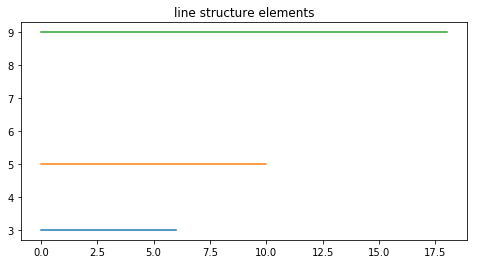

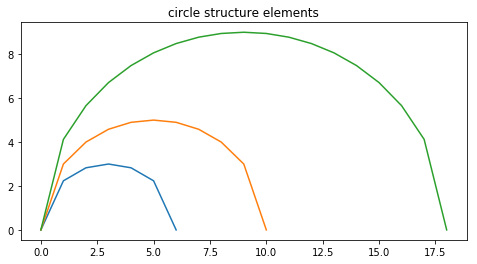

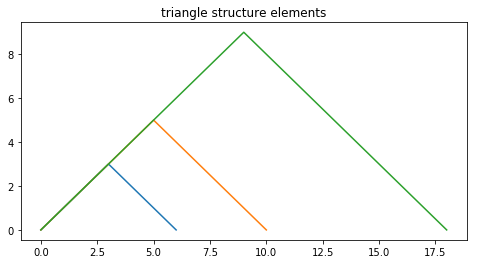

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def structure_element(radius,types):
    #type: 0-line,1-circle,2-triangle
    se = np.zeros(radius*2+1)
    if types == 0:
        se = se + radius
    if types == 1:
        for i in range(radius*2+1):
            se[i]= np.sqrt(radius*radius-(radius-i)*(radius-i))
    if types == 2:
        for i in range(radius+1):
            se[i] = i
            se[radius*2-i] = i
    return se

se1 = structure_element(3,0)
se2 = structure_element(5,0)
se3 = structure_element(9,0)
plt.figure(figsize=(8,4))
plt.title("line structure elements")
plt.plot(se1)
plt.plot(se2)
plt.plot(se3)
plt.show()

se1 = structure_element(3,1)
se2 = structure_element(5,1)
se3 = structure_element(9,1)
plt.figure(figsize=(8,4))
plt.title("circle structure elements")
plt.plot(se1)
plt.plot(se2)
plt.plot(se3)
plt.show()

se1 = structure_element(3,2)
se2 = structure_element(5,2)
se3 = structure_element(9,2)
plt.figure(figsize=(8,4))
plt.title("triangle structure elements")
plt.plot(se1)
plt.plot(se2)
plt.plot(se3)
plt.show()

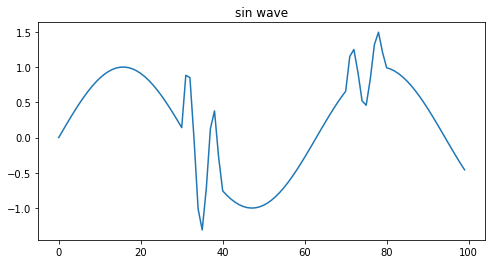

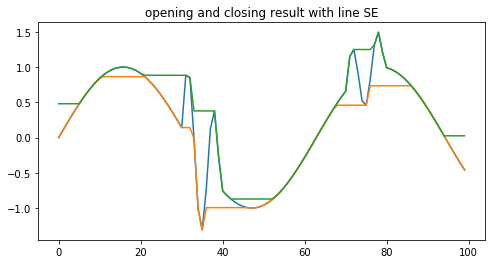

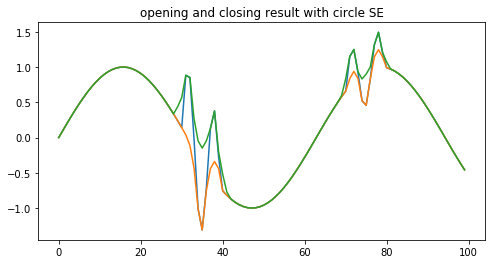

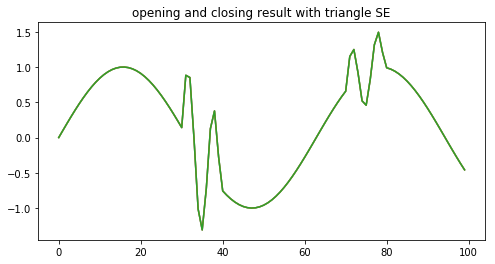

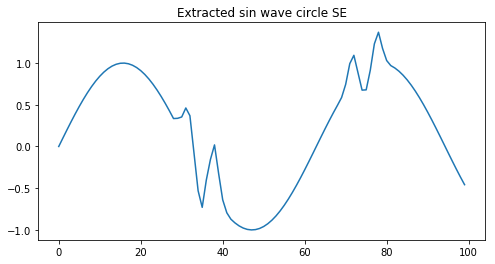

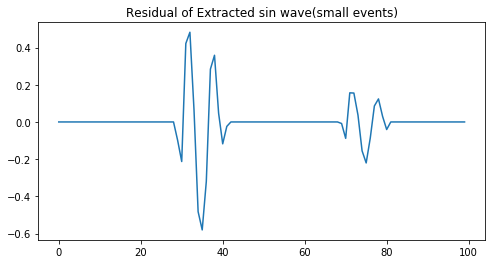

In [2]:
time        = np.arange(0, 10, 0.1);
data   = np.sin(time)
data_add = np.sin(np.arange(0,10))
data[30:40] = data[30:40] + data_add
data[70:80] = data[70:80] + data_add*0.5
r = 5
plt.figure(figsize=(8,4))
plt.title("sin wave")
plt.plot(data)
plt.show()

def erosion(data,se):
    r = (len(se)-1)/2
    l = len(se)
    data = np.insert(data,0,data[0].repeat(r),0)
    data = np.append(data,data[-1].repeat(r))
    result = np.zeros(len(data)-len(se)+1)
    for i in range(len(data)-len(se)+1):
        result[i] = min(data[i:i+len(se)]-se)
    return result

def dilation(data,se):
    r = (len(se)-1)/2
    l = len(se)
    data = np.insert(data,0,data[0].repeat(r),0)
    data = np.append(data,data[-1].repeat(r))
    result = np.zeros(len(data)-len(se)+1)
    for i in range(len(data)-len(se)+1):
        result[i] = max(data[i:i+len(se)]+se)
    return result

def opening(data,se):
    data = erosion(data,se)
    data = dilation(data,se)
    return data

def closing(data,se):
    data = dilation(data,se)
    data = erosion(data,se)
    return data

se = structure_element(5,0)
data1 = opening(data,se)
data2 = closing(data,se)

plt.figure(figsize=(8,4))
plt.title("opening and closing result with line SE")
plt.plot(data)
plt.plot(data1)
plt.plot(data2)
plt.show()

se = structure_element(5,1)
data1 = opening(data,se)
data2 = closing(data,se)

plt.figure(figsize=(8,4))
plt.title("opening and closing result with circle SE")
plt.plot(data)
plt.plot(data1)
plt.plot(data2)
plt.show()

se = structure_element(5,2)
data1 = opening(data,se)
data2 = closing(data,se)

plt.figure(figsize=(8,4))
plt.title("opening and closing result with triangle SE")
plt.plot(data)
plt.plot(data1)
plt.plot(data2)
plt.show()

se = structure_element(5,1)
data1 = opening(data,se)
data2 = closing(data,se)
sin_extract = (data1+data2)/2
residual = data - sin_extract

plt.figure(figsize=(8,4))
plt.title("Extracted sin wave circle SE")
plt.plot(sin_extract)
plt.show()

plt.figure(figsize=(8,4))
plt.title("Residual of Extracted sin wave(small events)")
plt.plot(residual)
plt.show()

In [3]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import pywt
from influxdb import InfluxDBClient
import operator
import scipy.signal as sg
import scipy as sp
import time as tm
import datetime as dt

from numpy.fft import rfft, irfft, rfftfreq
from scipy import fftpack
import pandas as pd


In [4]:
# label trajectory time
start_end_time = {
    'a673_corner': ["2020-12-05T16:33:20-05:00","2020-12-05T18:03:57-05:00"],
    'dc04_bedroomb': ["2020-12-05T16:20:00-05:00","2020-12-05T18:03:57-05:00"],
    '2a5f_corridor': ["2020-12-05T16:20:00-05:00","2020-12-05T18:03:57-05:00"],
    'ca46_sofa': ["2020-12-05T16:20:00-05:00","2020-12-05T18:03:57-05:00"],
    'ae69_bedrooma': ["2020-12-05T16:20:00-05:00","2020-12-05T18:03:57-05:00"],
    'ab05_laundry': ["2020-12-05T16:20:00-05:00","2020-12-05T18:03:57-05:00"]
}

### with normalization

In [47]:
def aggrmorphology(start_time,end_time,filenames,personname,trajectory):
    '''
    example:
    start_time = '16:39:20'
    end_time = '16:39:50'
    filename = 'a673_corner.csv'
    '''
    
    print('{}, {}, {}, {}'.format(start_time,end_time,personname,trajectory))
    
    start_timestamp = tm.mktime(dt.datetime.strptime(start_time, "%H:%M:%S").timetuple())
    end_timestamp = tm.mktime(dt.datetime.strptime(end_time, "%H:%M:%S").timetuple())
    
    closing_results = []
    peaks = []
    
    for filename in filenames:
        #print('#'*115)
        with open(filename, newline='') as csvfile:
            spamreader = csv.reader(csvfile)
            seis = []
            first = True
            for row in spamreader:
                if first:
                    first = False
                    continue
                row = row[0].split(';')
                curr_time = row[1].strip('"').split('T')[1].split('-')[0]
                curr_timestamp = tm.mktime(dt.datetime.strptime(curr_time, "%H:%M:%S").timetuple())
                if curr_timestamp >= start_timestamp and curr_timestamp <= end_timestamp:
                    seis.append(row[2])
            seis = np.array(seis)
            seis = seis.astype(np.float)
            #print(seis)
            
        if len(seis) == 0:
            continue
        data = seis[:]
        data = (data-np.mean(data)) / (np.max(data)-np.min(data))*10000
        #print(data)
        
        '''
        plt.figure(figsize=(16,4))
        plt.title("raw footstep - {}".format(filename))
        plt.plot(data)
        plt.show()
        '''

        se = structure_element(20,1)
        data1 = opening(data,se)
        data2 = closing(data,se)

        '''
        plt.figure(figsize=(16,4))
        plt.title("closing result")
        plt.plot(data2)
        plt.show()
        '''

        ####### peak detection
        x = data2
        peaks1, _ = sp.signal.find_peaks(x, height=0)
        
        '''
        plt.figure(figsize=(16, 4))
        plt.xlabel('Time(0.01s)')
        plt.ylabel('Vib signal')
        plt.title("closing result with finding peaks")
        plt.plot(x)
        plt.plot(peaks1, x[peaks1], "x")
        #plt.plot(np.zeros_like(x), "--", color="gray")
        plt.show()
        '''
        
        closing_results.append(x)
        peaks.append(peaks1)
    
    if not len(closing_results[0]) == len(closing_results[1]):
        closing_results.pop(0)
    closing_results = np.array(closing_results)
    '''
    print('#'*115)
    plt.figure(figsize=(26, 20))
    plt.xlabel('Time(0.01s)')
    plt.ylabel('Vib signal')
    plt.title("closing result with finding peaks")
    for i in range(closing_results.shape[0]):
        x = closing_results[i]
        plt.plot(x)
    plt.legend(filenames,loc='upper right')
    '''
    
    # aggregate closing results
    print('#'*115)
    aggr_closing_results = []
    for i in range(closing_results.shape[1]):
        mx = np.max(closing_results[:,i])
        aggr_closing_results.append(mx)
    aggr_closing_results = np.array(aggr_closing_results)
    x = aggr_closing_results
    peaks1, _ = sp.signal.find_peaks(x, height=0)
    plt.figure(figsize=(26, 20))
    plt.xlabel('Time(0.01s)')
    plt.ylabel('Vib signal')
    plt.title("maximum closing result with finding peaks - {}, {}".format(personname,trajectory))
    plt.plot(x)
    plt.plot(peaks1, x[peaks1], "x")
    
    return len(peaks1)


In [ ]:
label_trajectory_filename = 'label_trajectory-time.xlsx'
sheetnames = ['Sheet1','Sheet2','Sheet3','Sheet4','Sheet5']
filenames = ['a673_corner.csv','dc04_bedroomb.csv','2a5f_corridor.csv',
             'ca46_sofa.csv','ae69_bedrooma.csv','ab05_laundry.csv']
footstep_count = {'Yu': [None for _ in range(5)],
                 'Shushan': [None for _ in range(5)],
                 'Huimin': [None for _ in range(5)],
                 'Zhen': [None for _ in range(5)],
                 'Hou': [None for _ in range(5)],
                 'Kai': [None for _ in range(5)],
                 'Sili': [None for _ in range(5)]}

for i in range(len(sheetnames)):
    sheetname = sheetnames[i]
    df = pd.read_excel(label_trajectory_filename,sheet_name=sheetname)
    personnames = list(df.index)
    for personname in personnames:
        time = list(map(str,list(df.loc[personname,:])))
        time = [t for t in time if not t=='nan']
        start_time = time[0]
        end_time = time[-1]
        cnt = aggrmorphology(start_time,end_time,filenames,personname,sheetname)
        footstep_count[personname][i] = cnt

print(pd.DataFrame(footstep_count))

16:21:00, 16:21:58, Yu, Sheet1
###################################################################################################################
16:23:30, 16:24:40, Shushan, Sheet1
###################################################################################################################
16:26:00, 16:27:03, Huimin, Sheet1
###################################################################################################################
16:28:00, 16:28:59, Zhen, Sheet1


In [43]:
result_df = pd.DataFrame(footstep_count)
result_df.to_csv('normalization_result_df.csv')
result_df

,Yu,Shushan,Huimin,Zhen,Hou,Kai,Sili
0,1140,1451.0,1460.0,1346,1468,1320.0,1474.0
1,792,812.0,672.0,460,654,683.0,677.0
2,626,NaN,NaN,817,646,NaN,NaN
3,762,751.0,656.0,566,592,693.0,630.0
4,1649,1691.0,1672.0,1995,1686,1402.0,1776.0


### without normalization

In [45]:
def aggrmorphology(start_time,end_time,filenames,personname,trajectory):
    '''
    example:
    start_time = '16:39:20'
    end_time = '16:39:50'
    filename = 'a673_corner.csv'
    '''
    
    print('{}, {}, {}, {}'.format(start_time,end_time,personname,trajectory))
    
    start_timestamp = tm.mktime(dt.datetime.strptime(start_time, "%H:%M:%S").timetuple())
    end_timestamp = tm.mktime(dt.datetime.strptime(end_time, "%H:%M:%S").timetuple())
    
    closing_results = []
    peaks = []
    
    for filename in filenames:
        #print('#'*115)
        with open(filename, newline='') as csvfile:
            spamreader = csv.reader(csvfile)
            seis = []
            first = True
            for row in spamreader:
                if first:
                    first = False
                    continue
                row = row[0].split(';')
                curr_time = row[1].strip('"').split('T')[1].split('-')[0]
                curr_timestamp = tm.mktime(dt.datetime.strptime(curr_time, "%H:%M:%S").timetuple())
                if curr_timestamp >= start_timestamp and curr_timestamp <= end_timestamp:
                    seis.append(row[2])
            seis = np.array(seis)
            seis = seis.astype(np.float)
            #print(seis)
            
        if len(seis) == 0:
            continue
        data = seis[:]
        #data = (data-np.min(data)) / (np.max(data)-np.min(data))
        #print(data)
        
        '''
        plt.figure(figsize=(16,4))
        plt.title("raw footstep - {}".format(filename))
        plt.plot(data)
        plt.show()
        '''

        se = structure_element(20,1)
        data1 = opening(data,se)
        data2 = closing(data,se)

        '''
        plt.figure(figsize=(16,4))
        plt.title("closing result")
        plt.plot(data2)
        plt.show()
        '''

        ####### peak detection
        x = data2
        peaks1, _ = sp.signal.find_peaks(x, height=0)
        
        '''
        plt.figure(figsize=(16, 4))
        plt.xlabel('Time(0.01s)')
        plt.ylabel('Vib signal')
        plt.title("closing result with finding peaks")
        plt.plot(x)
        plt.plot(peaks1, x[peaks1], "x")
        #plt.plot(np.zeros_like(x), "--", color="gray")
        plt.show()
        '''
        
        closing_results.append(x)
        peaks.append(peaks1)
    
    if not len(closing_results[0]) == len(closing_results[1]):
        closing_results.pop(0)
    closing_results = np.array(closing_results)
    '''
    print('#'*115)
    plt.figure(figsize=(26, 20))
    plt.xlabel('Time(0.01s)')
    plt.ylabel('Vib signal')
    plt.title("closing result with finding peaks")
    for i in range(closing_results.shape[0]):
        x = closing_results[i]
        plt.plot(x)
    plt.legend(filenames,loc='upper right')
    '''
    
    # aggregate closing results
    print('#'*115)
    aggr_closing_results = []
    for i in range(closing_results.shape[1]):
        mx = np.max(closing_results[:,i])
        aggr_closing_results.append(mx)
    aggr_closing_results = np.array(aggr_closing_results)
    x = aggr_closing_results
    peaks1, _ = sp.signal.find_peaks(x, height=0)
    plt.figure(figsize=(26, 20))
    plt.xlabel('Time(0.01s)')
    plt.ylabel('Vib signal')
    plt.title("maximum closing result with finding peaks - {}, {}".format(personname,trajectory))
    plt.plot(x)
    plt.plot(peaks1, x[peaks1], "x")
    
    return len(peaks1)

16:21:00, 16:21:58, Yu, Sheet1
###################################################################################################################
16:23:30, 16:24:40, Shushan, Sheet1
###################################################################################################################
16:26:00, 16:27:03, Huimin, Sheet1
###################################################################################################################
16:28:00, 16:28:59, Zhen, Sheet1
###################################################################################################################
16:31:00, 16:32:08, Hou, Sheet1
###################################################################################################################
16:33:00, 16:34:00, Kai, Sheet1
###################################################################################################################
16:35:00, 16:36:00, Sili, Sheet1
########################################################################

,Yu,Shushan,Huimin,Zhen,Hou,Kai,Sili
0,126,187.0,142.0,130,161,149.0,159.0
1,104,86.0,87.0,59,73,74.0,74.0
2,61,NaN,NaN,94,77,NaN,NaN
3,98,73.0,79.0,66,69,78.0,59.0
4,191,178.0,199.0,256,206,168.0,190.0


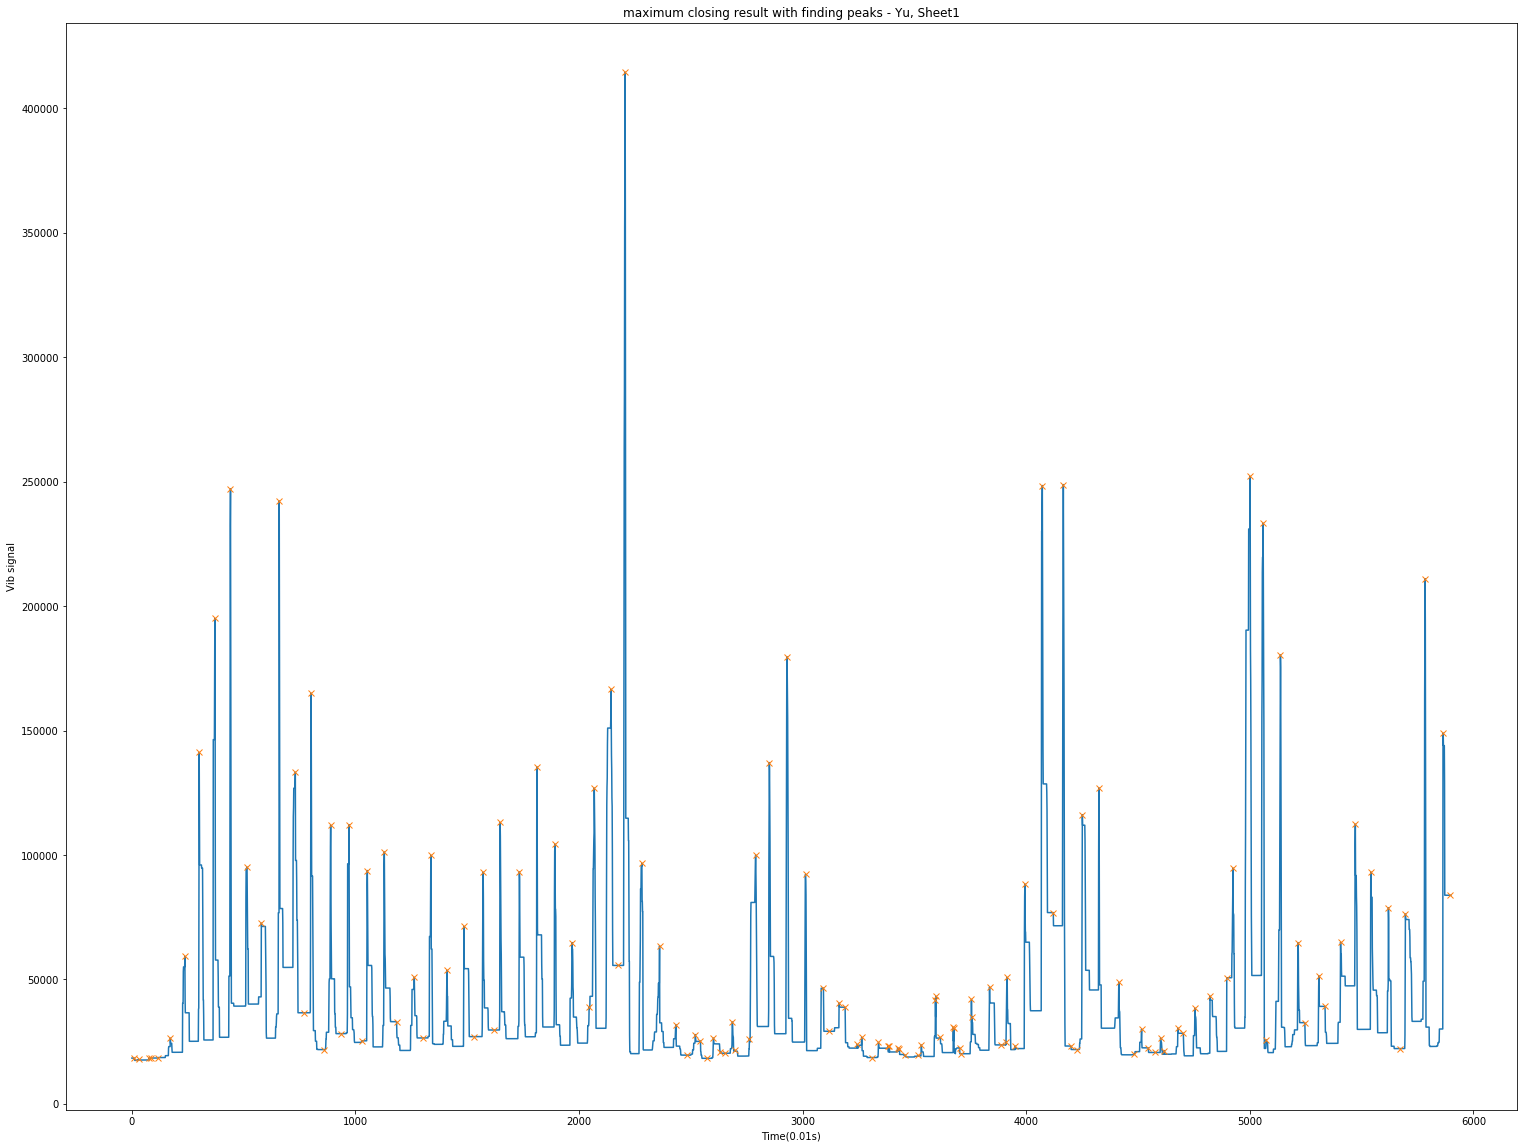

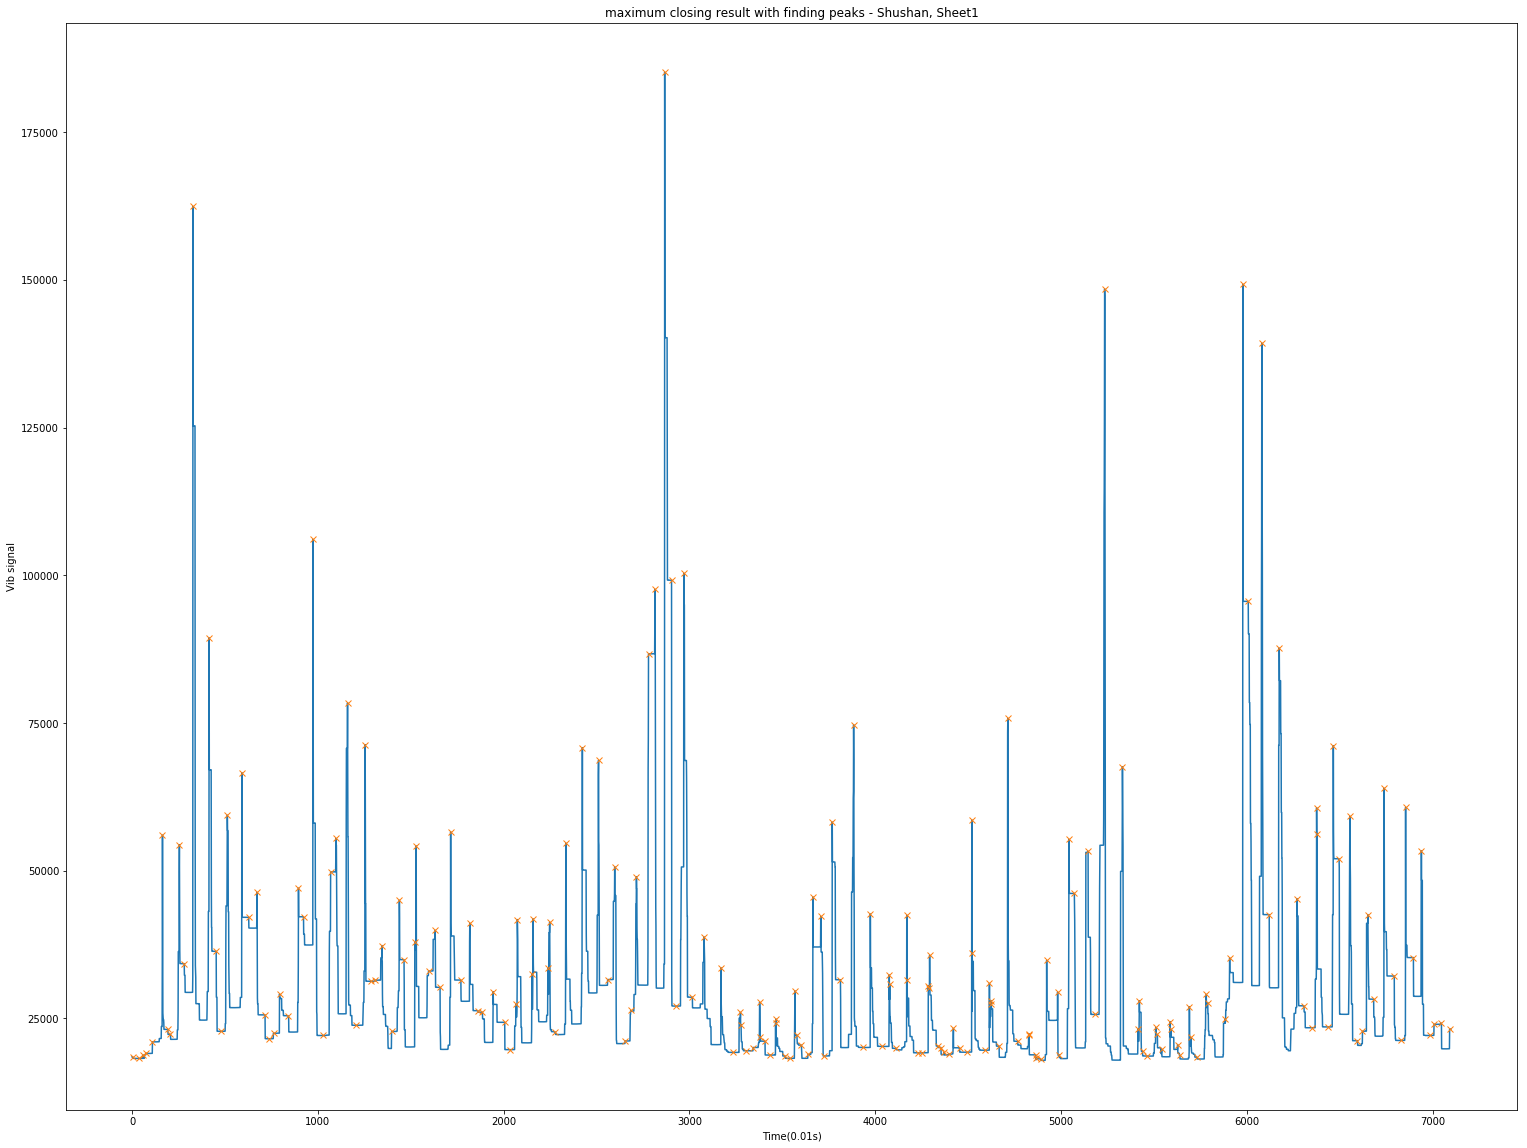

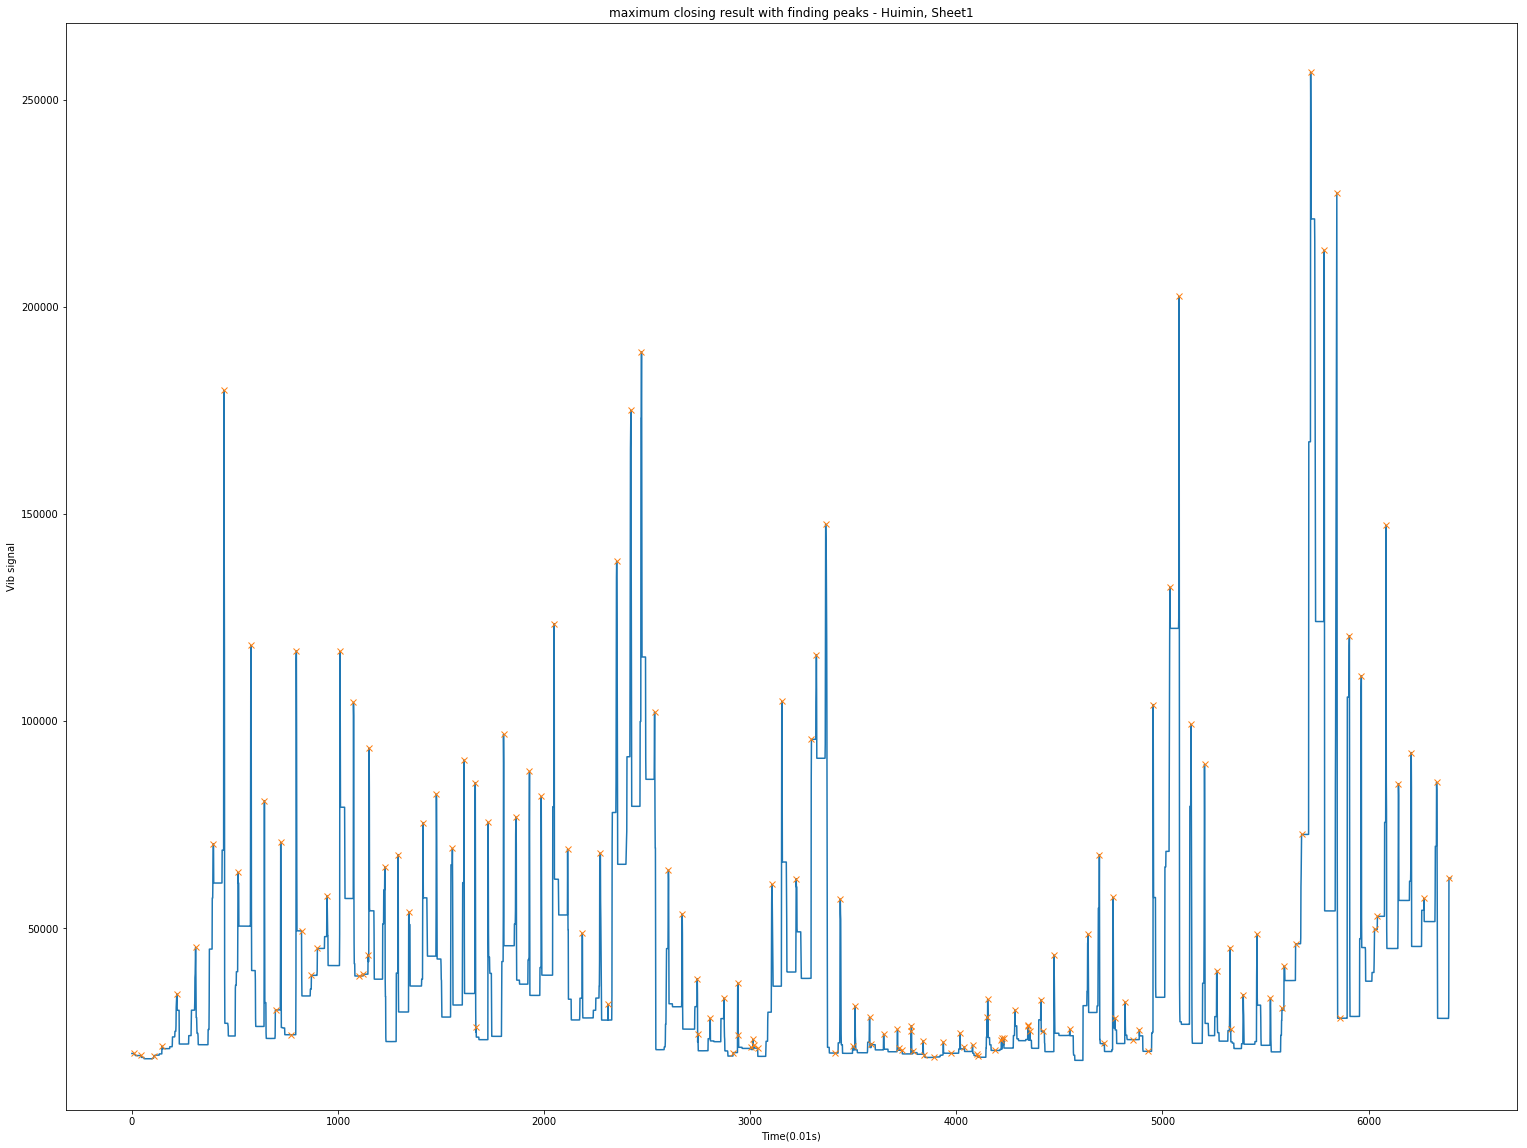

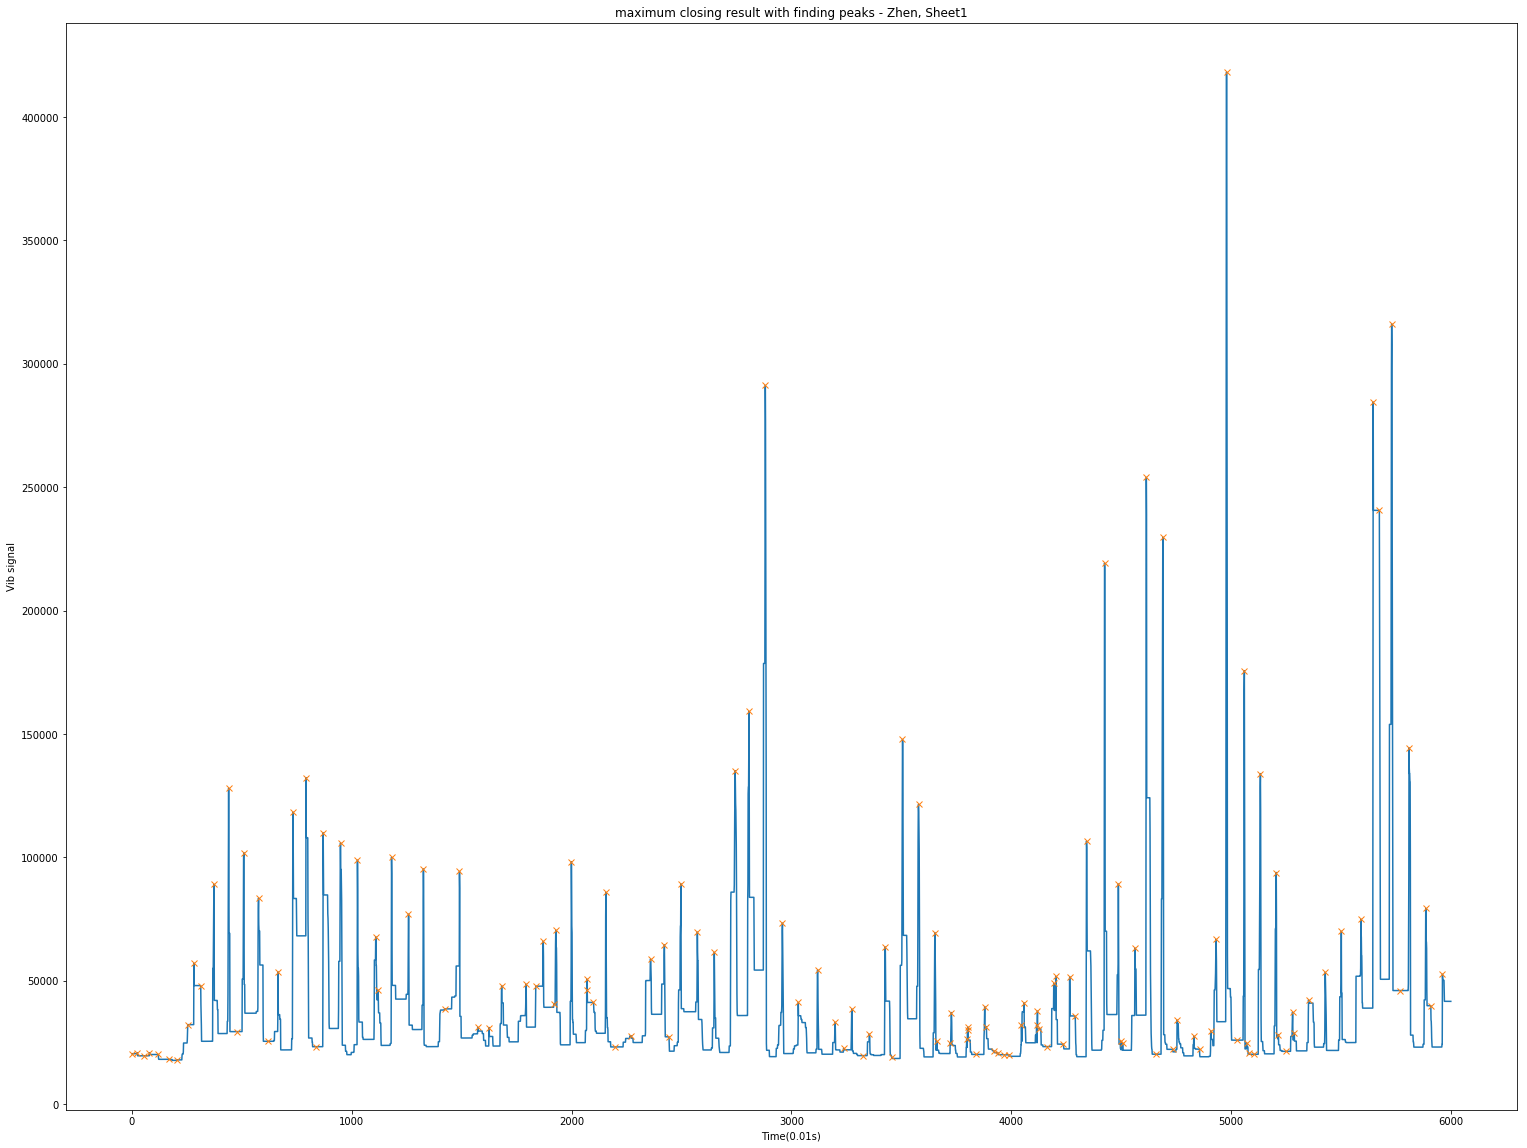

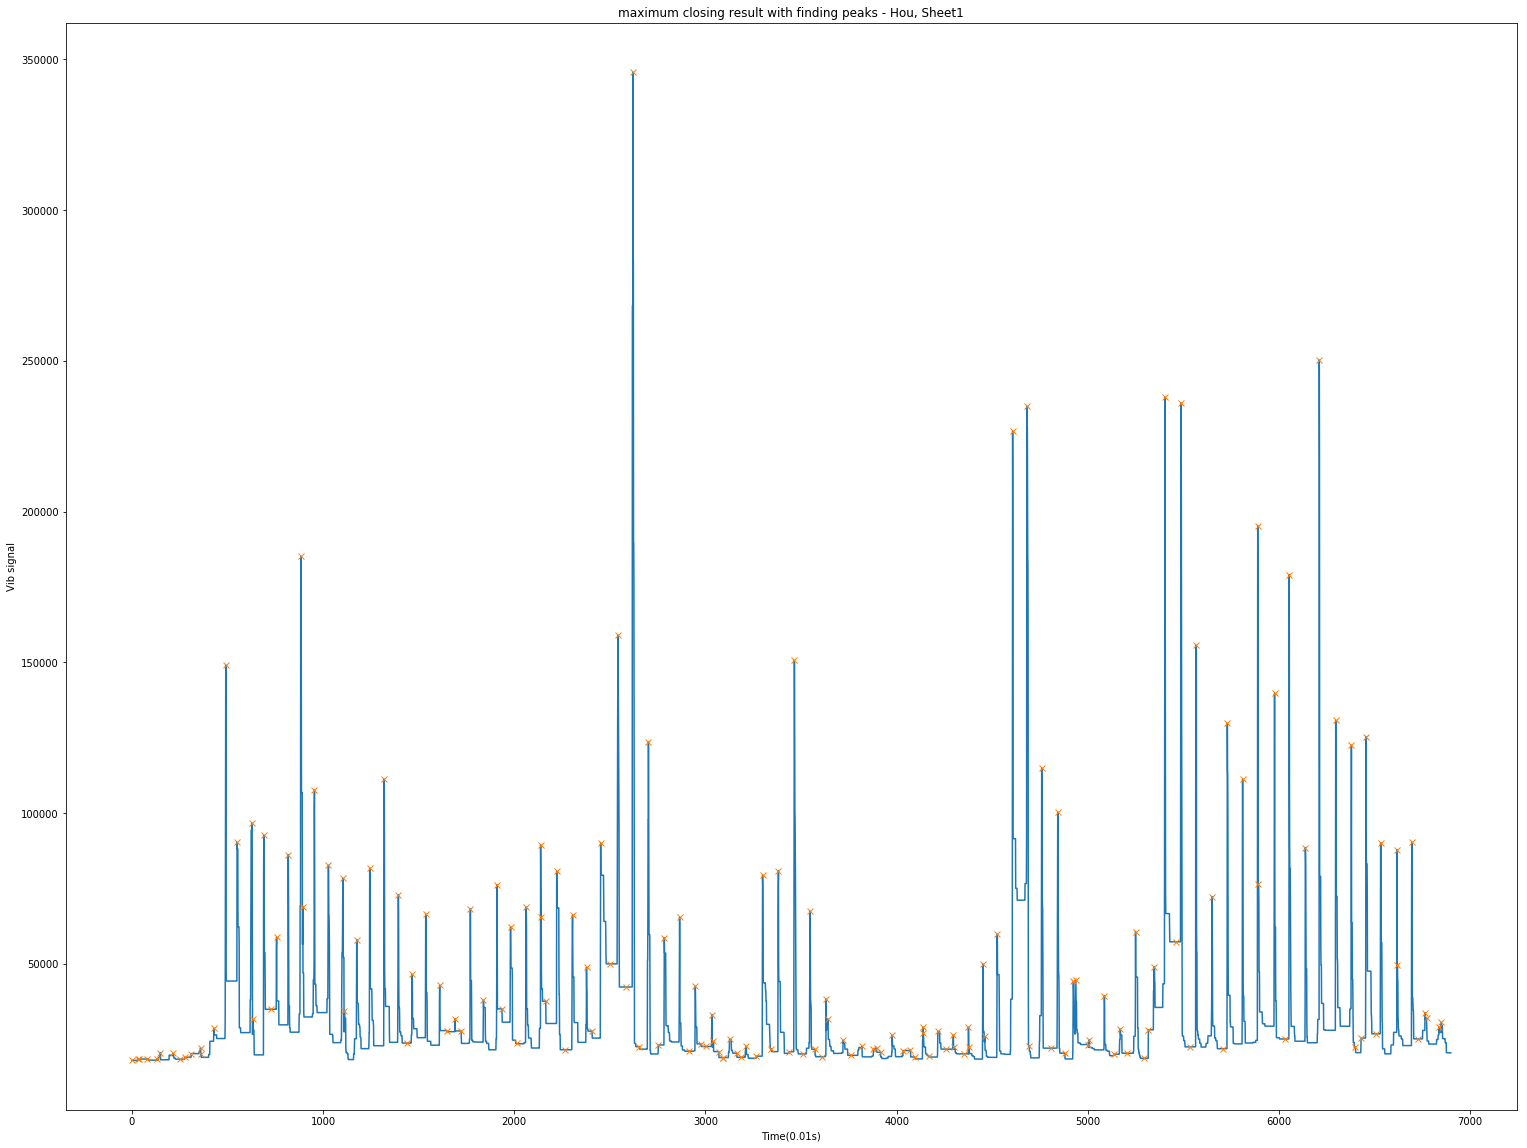

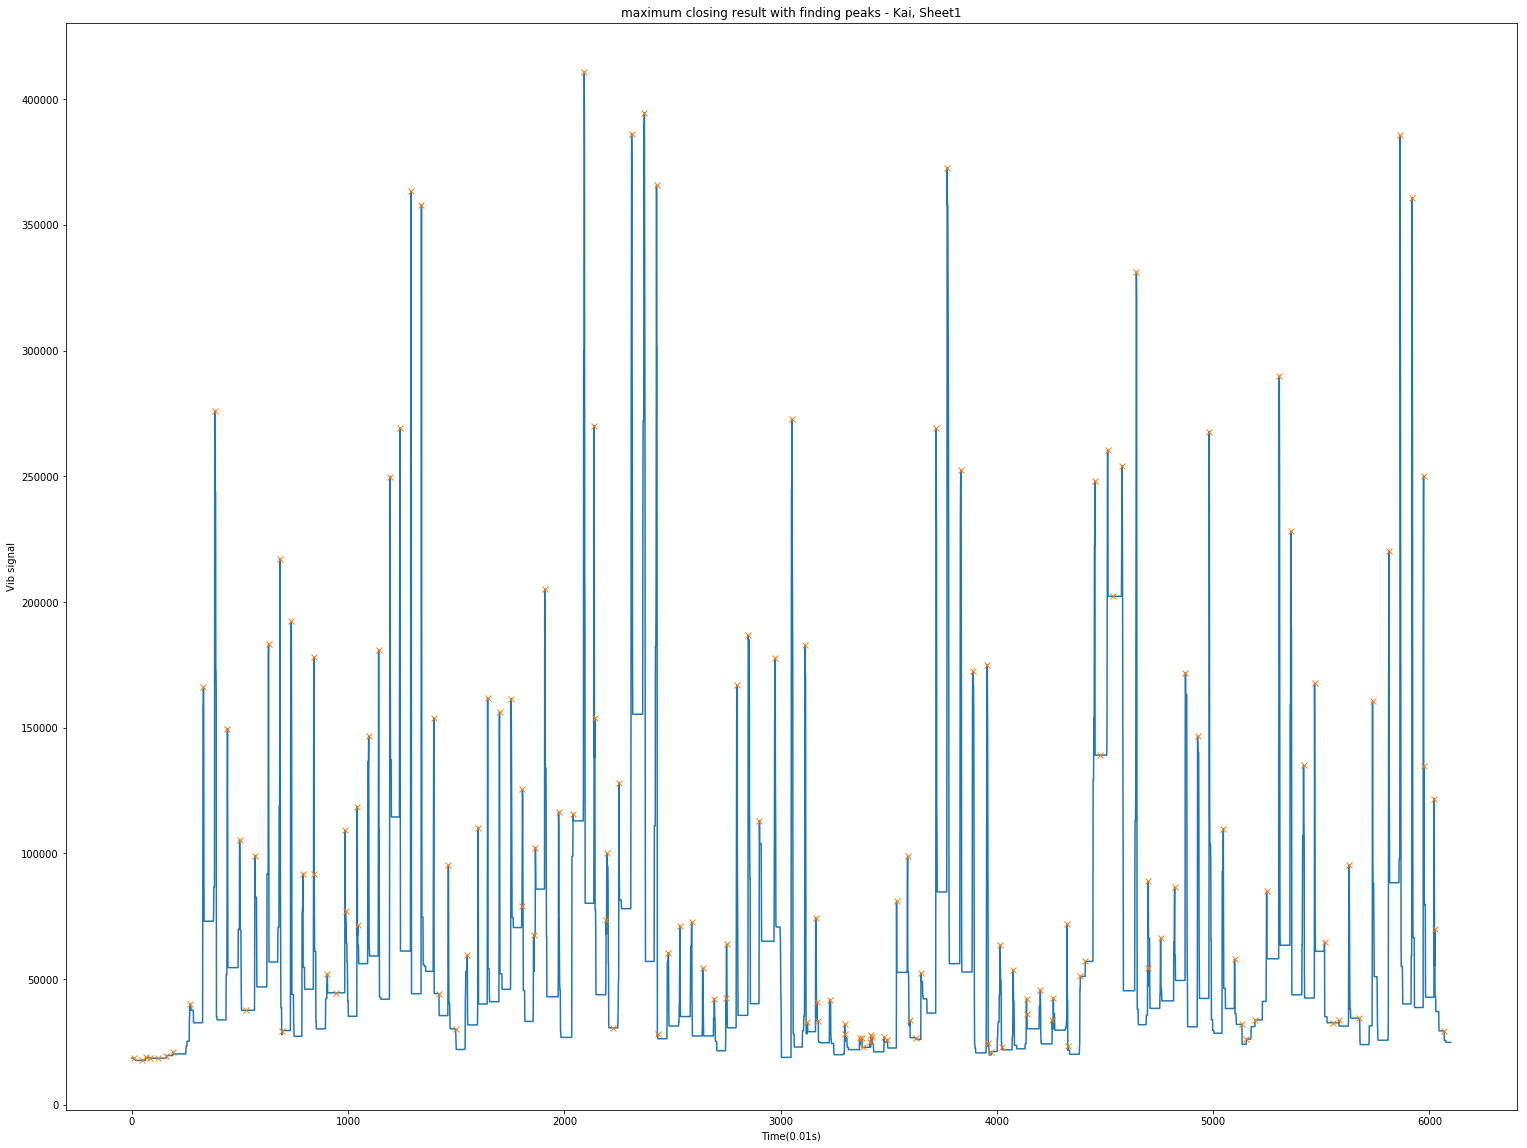

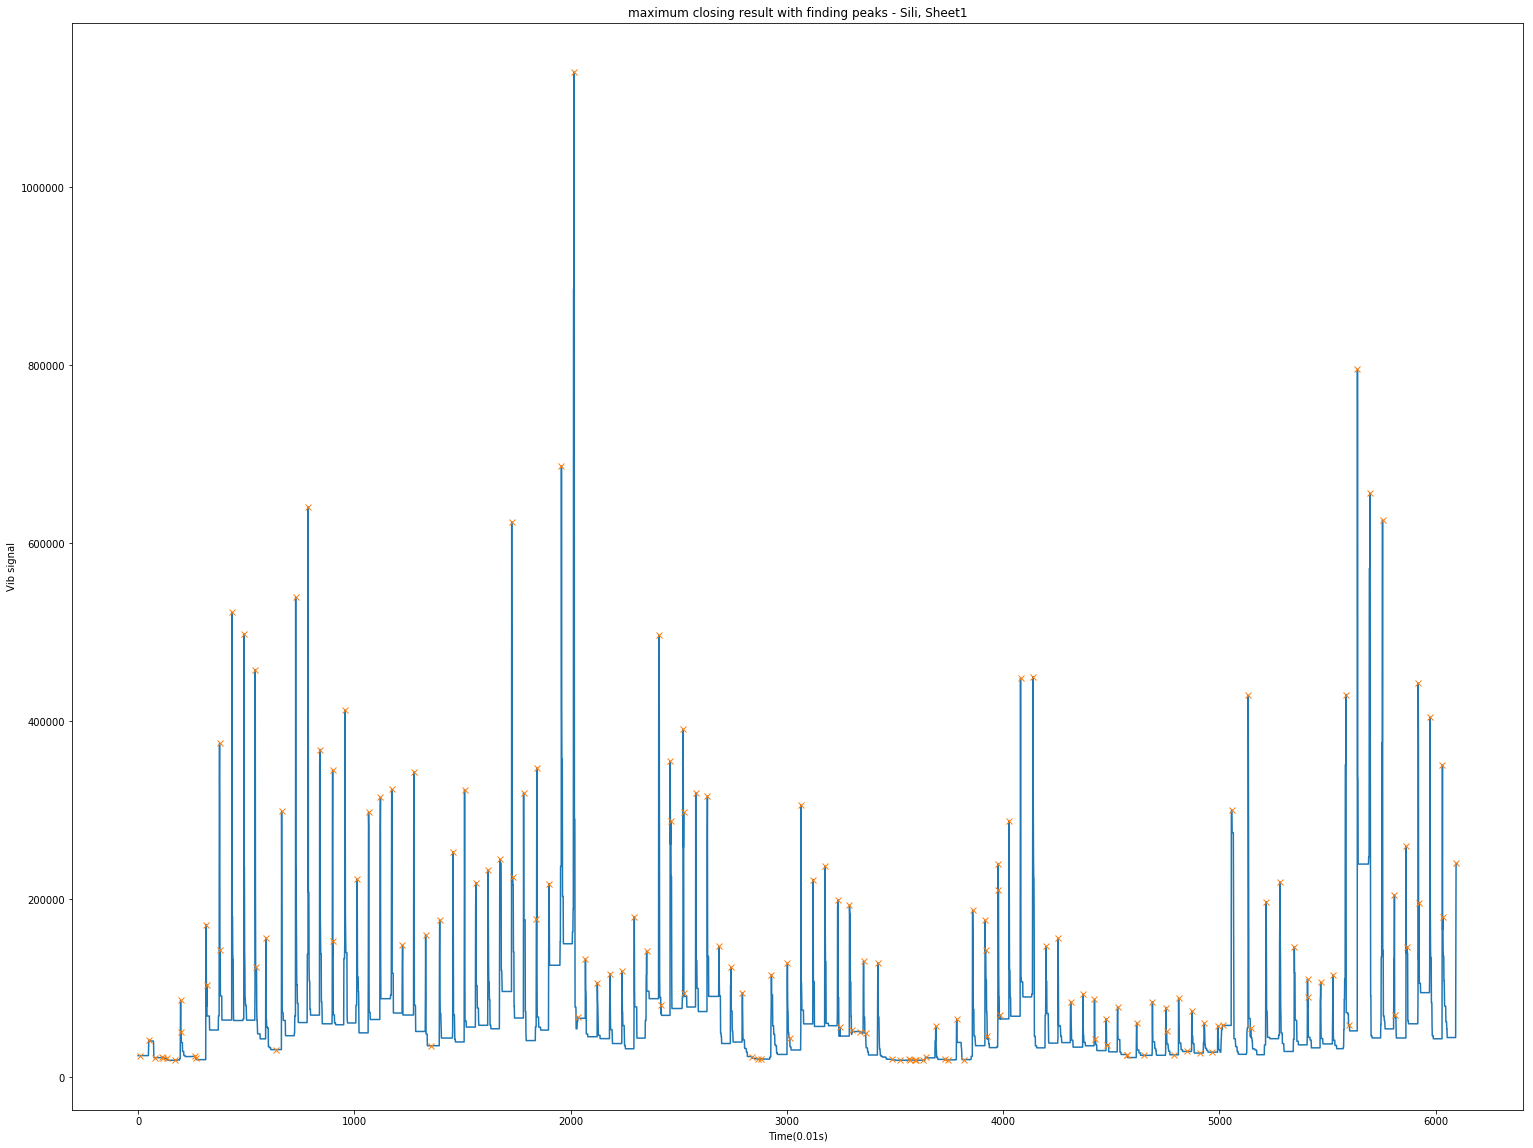

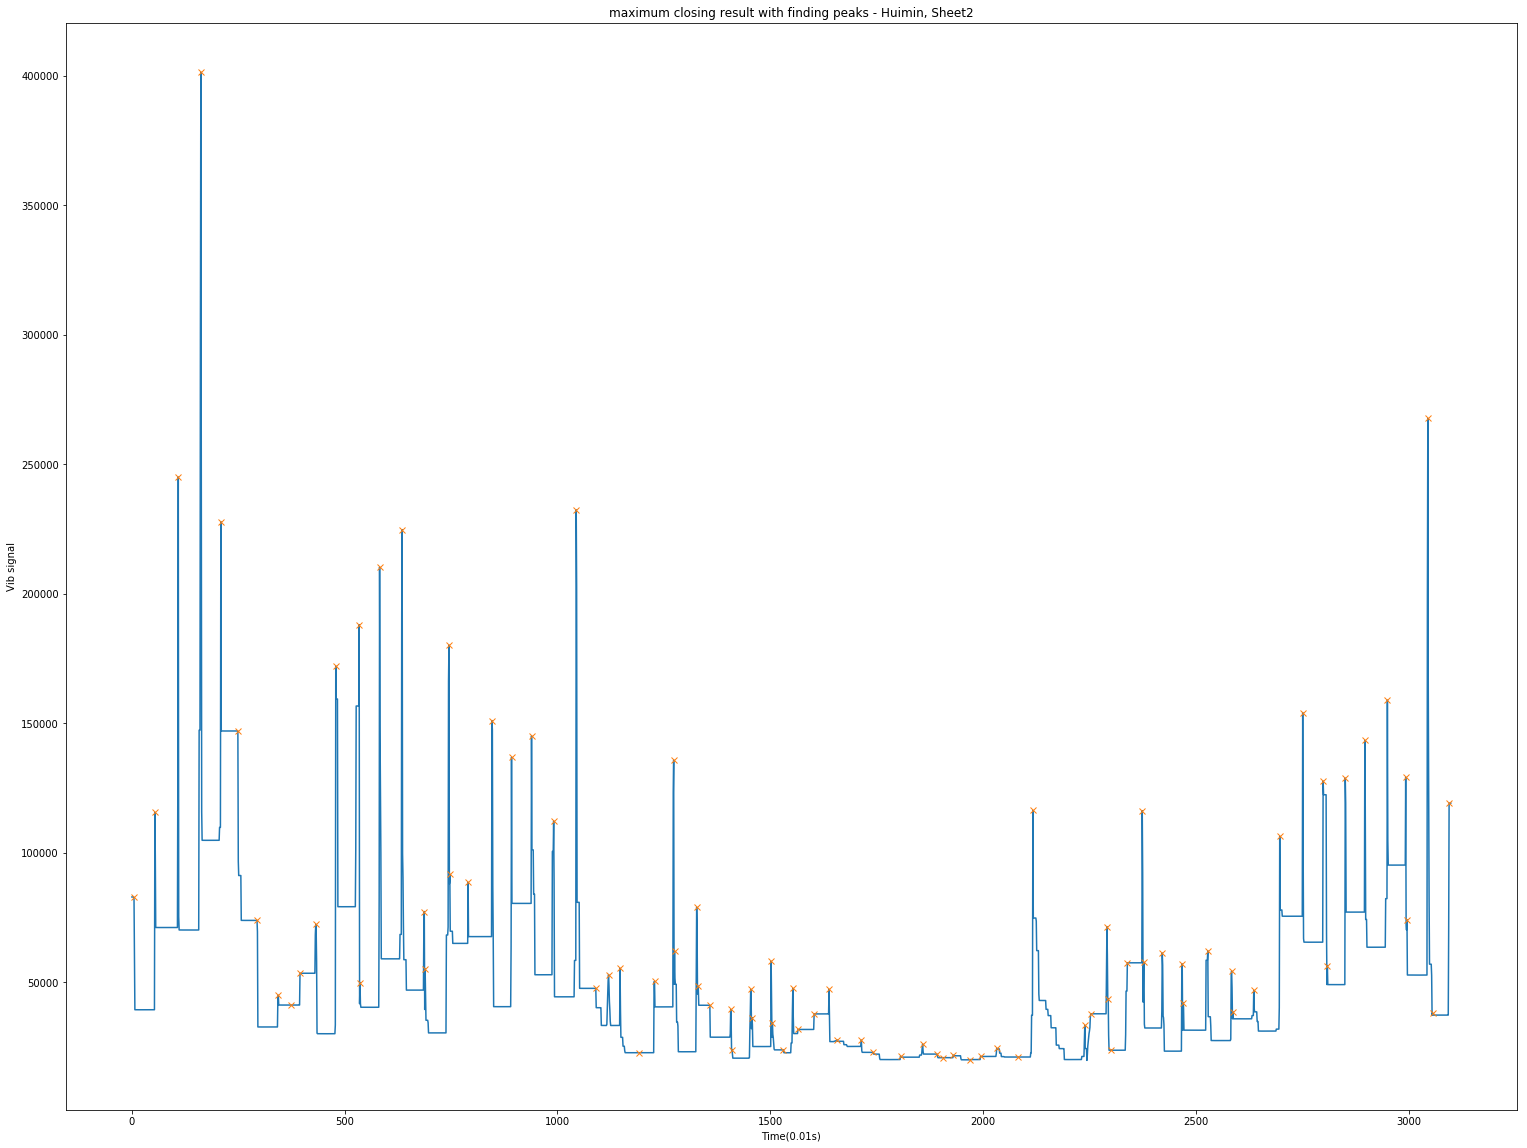

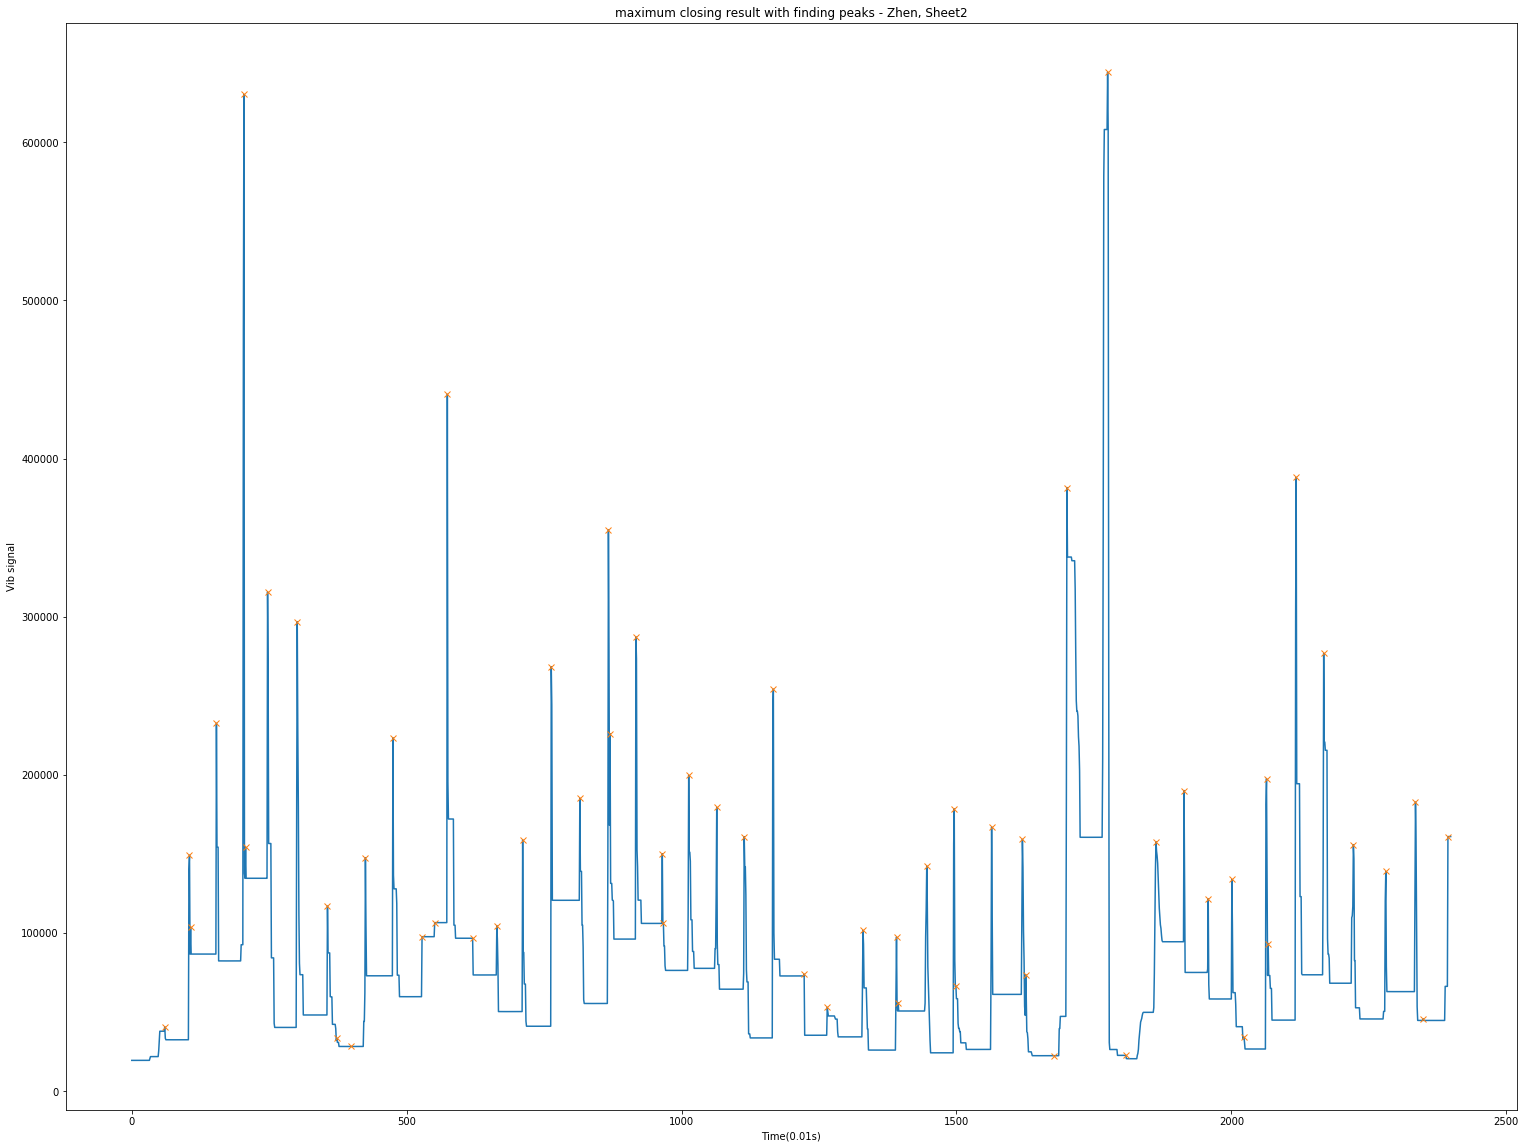

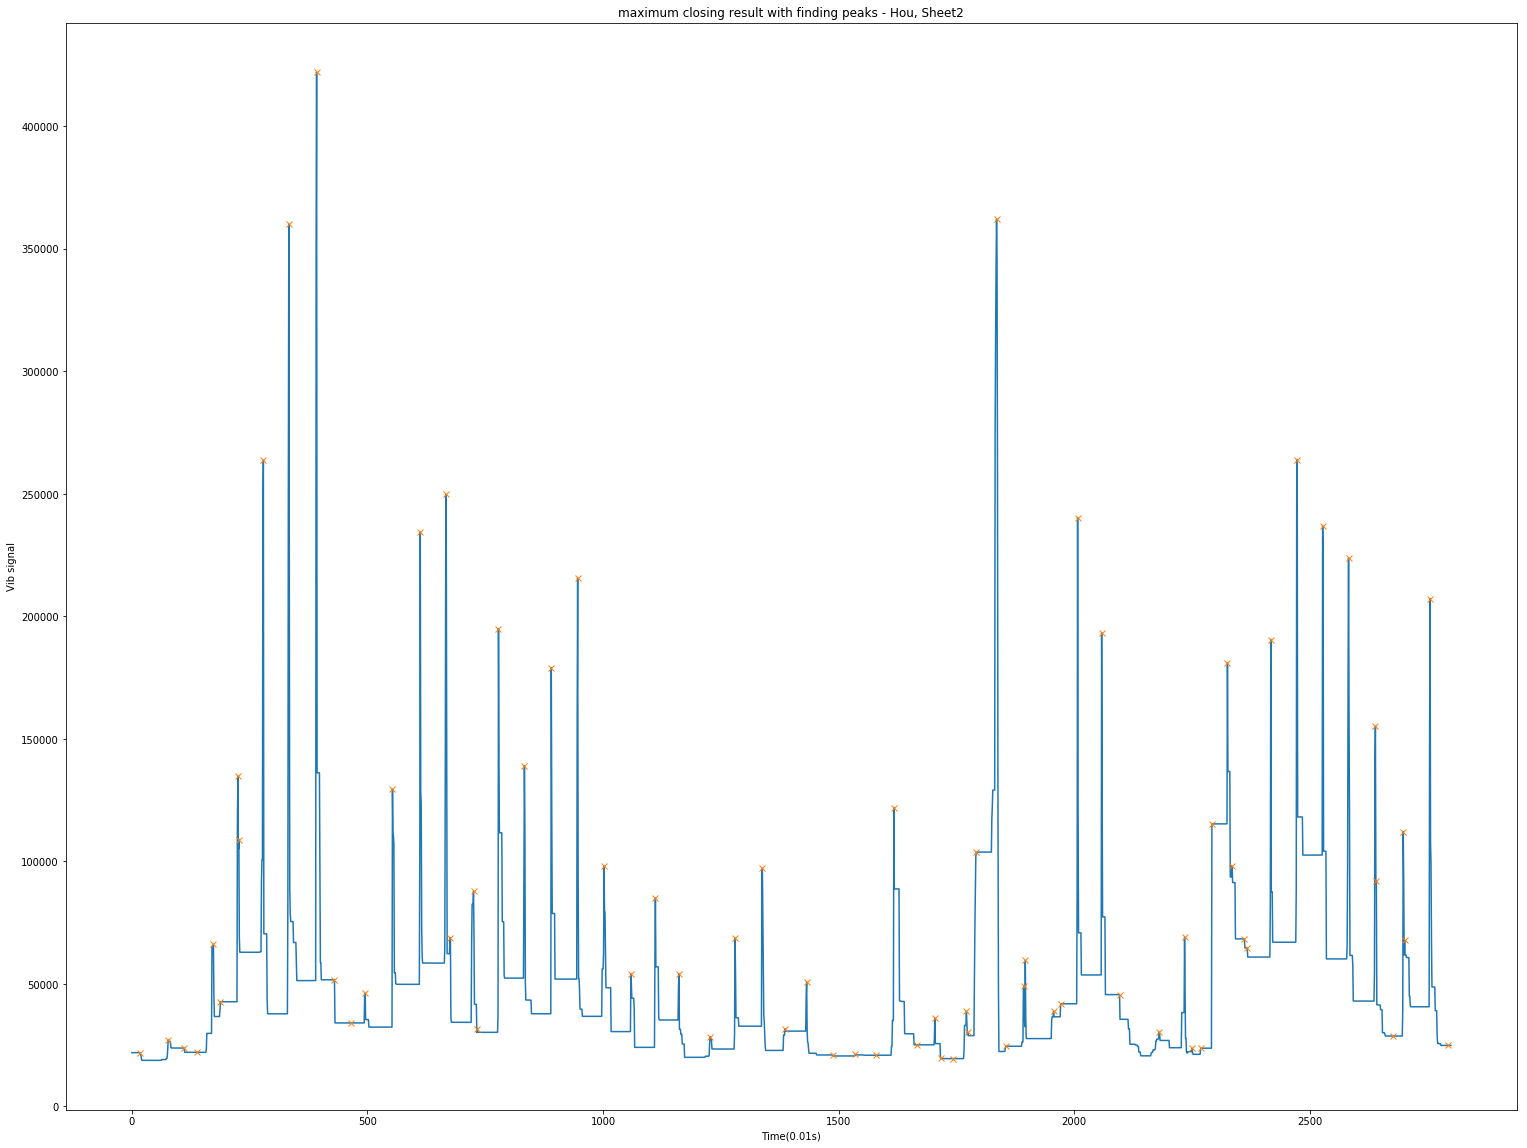

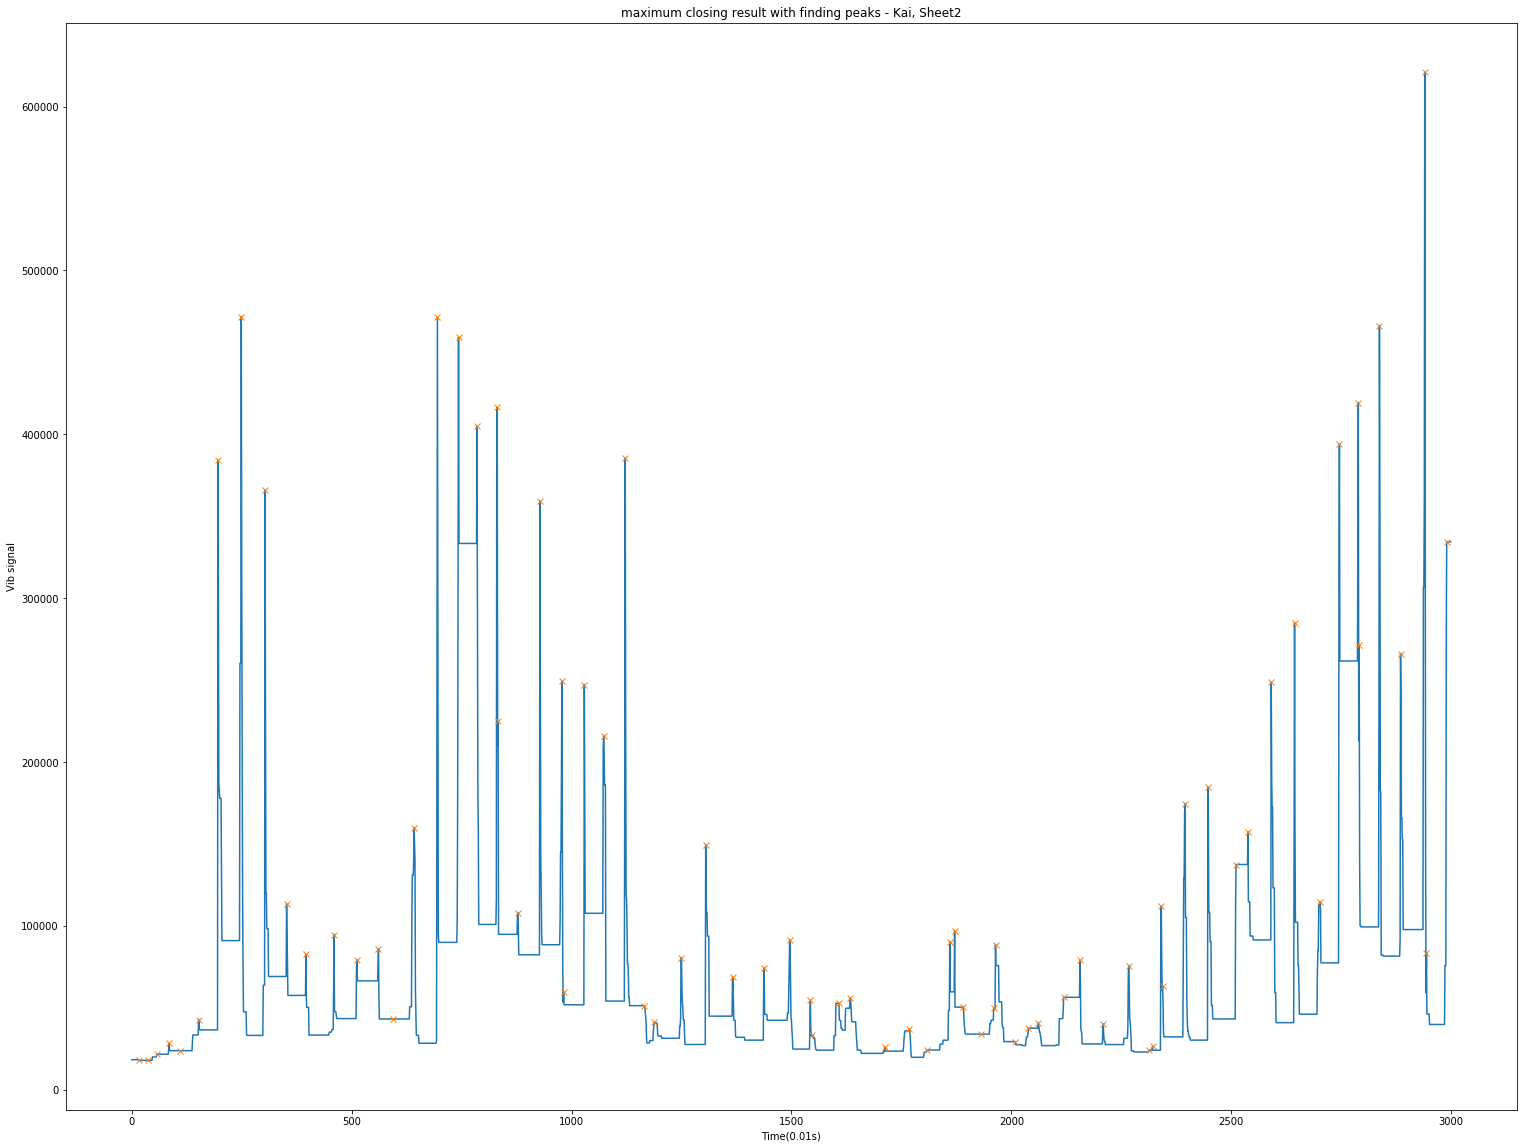

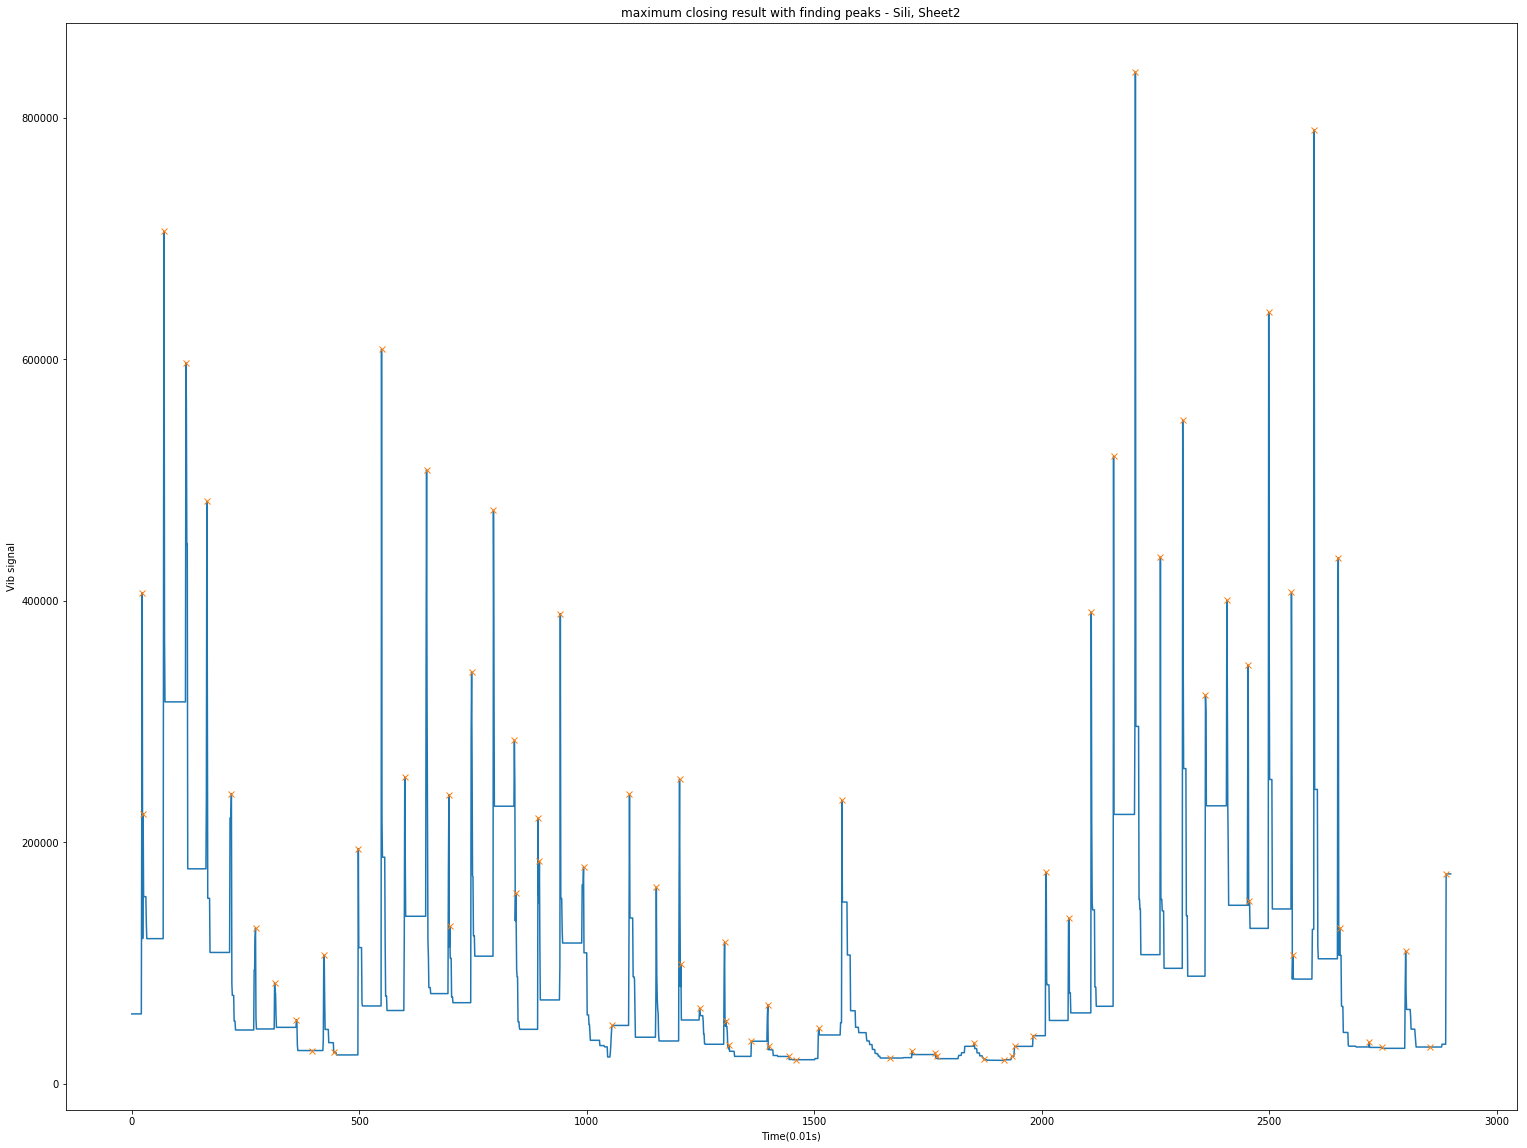

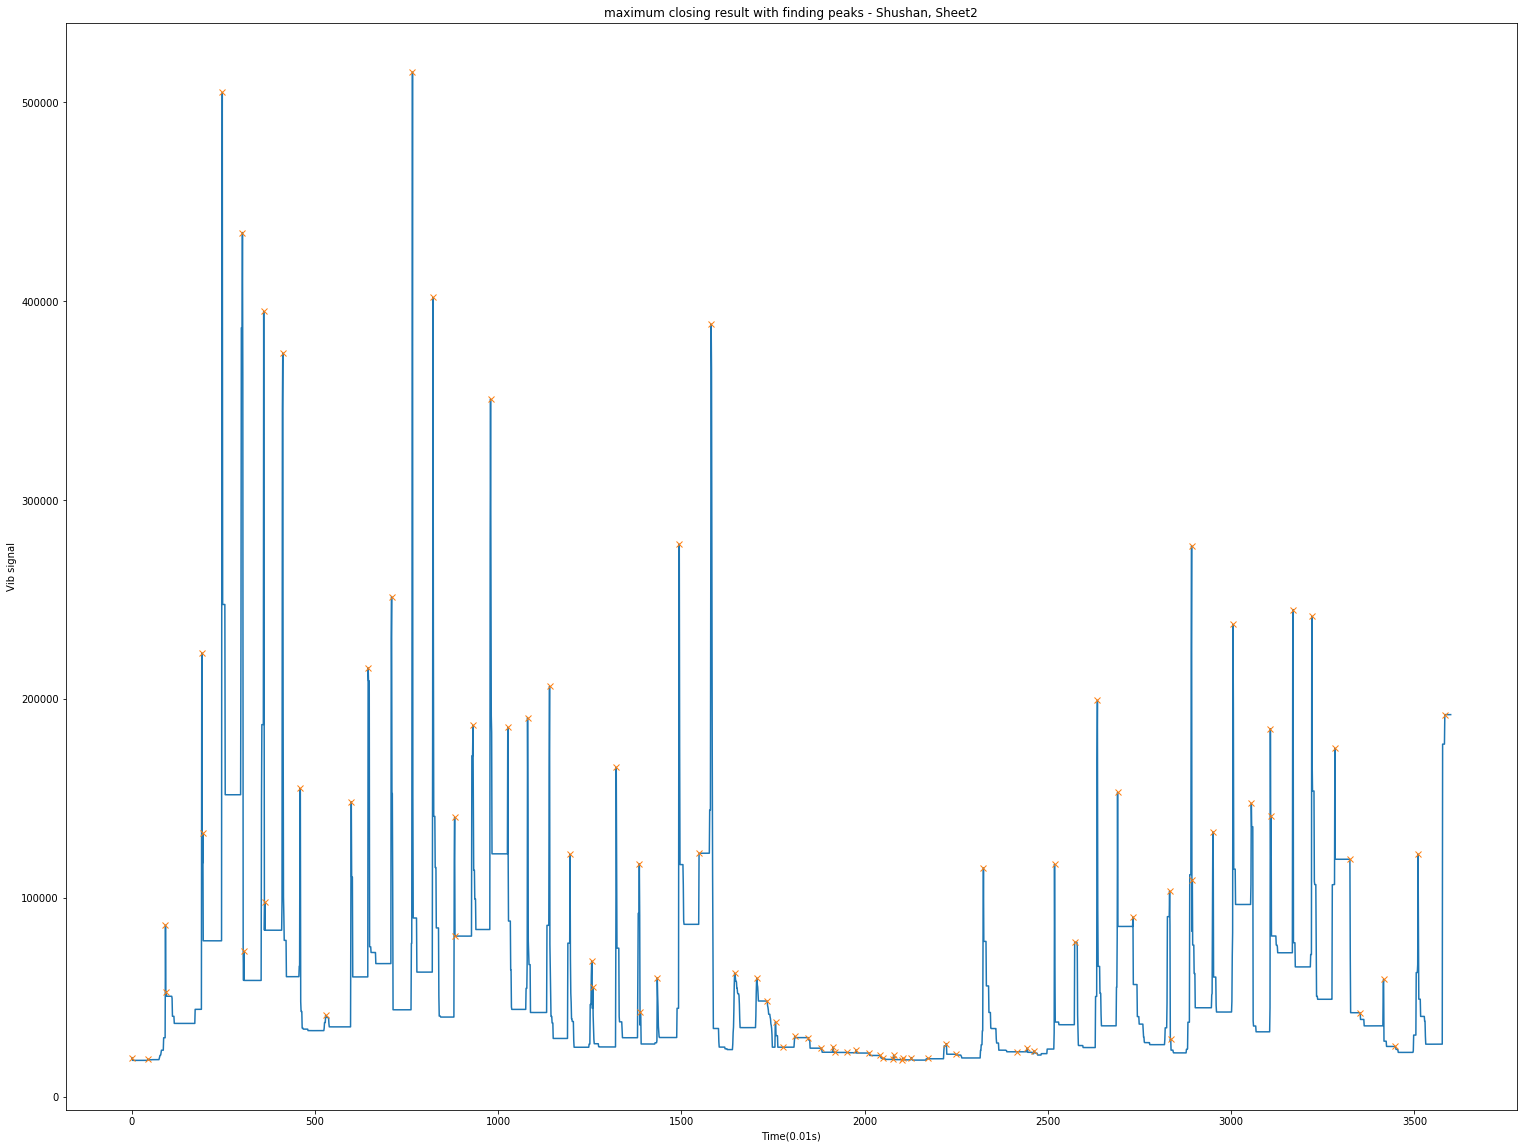

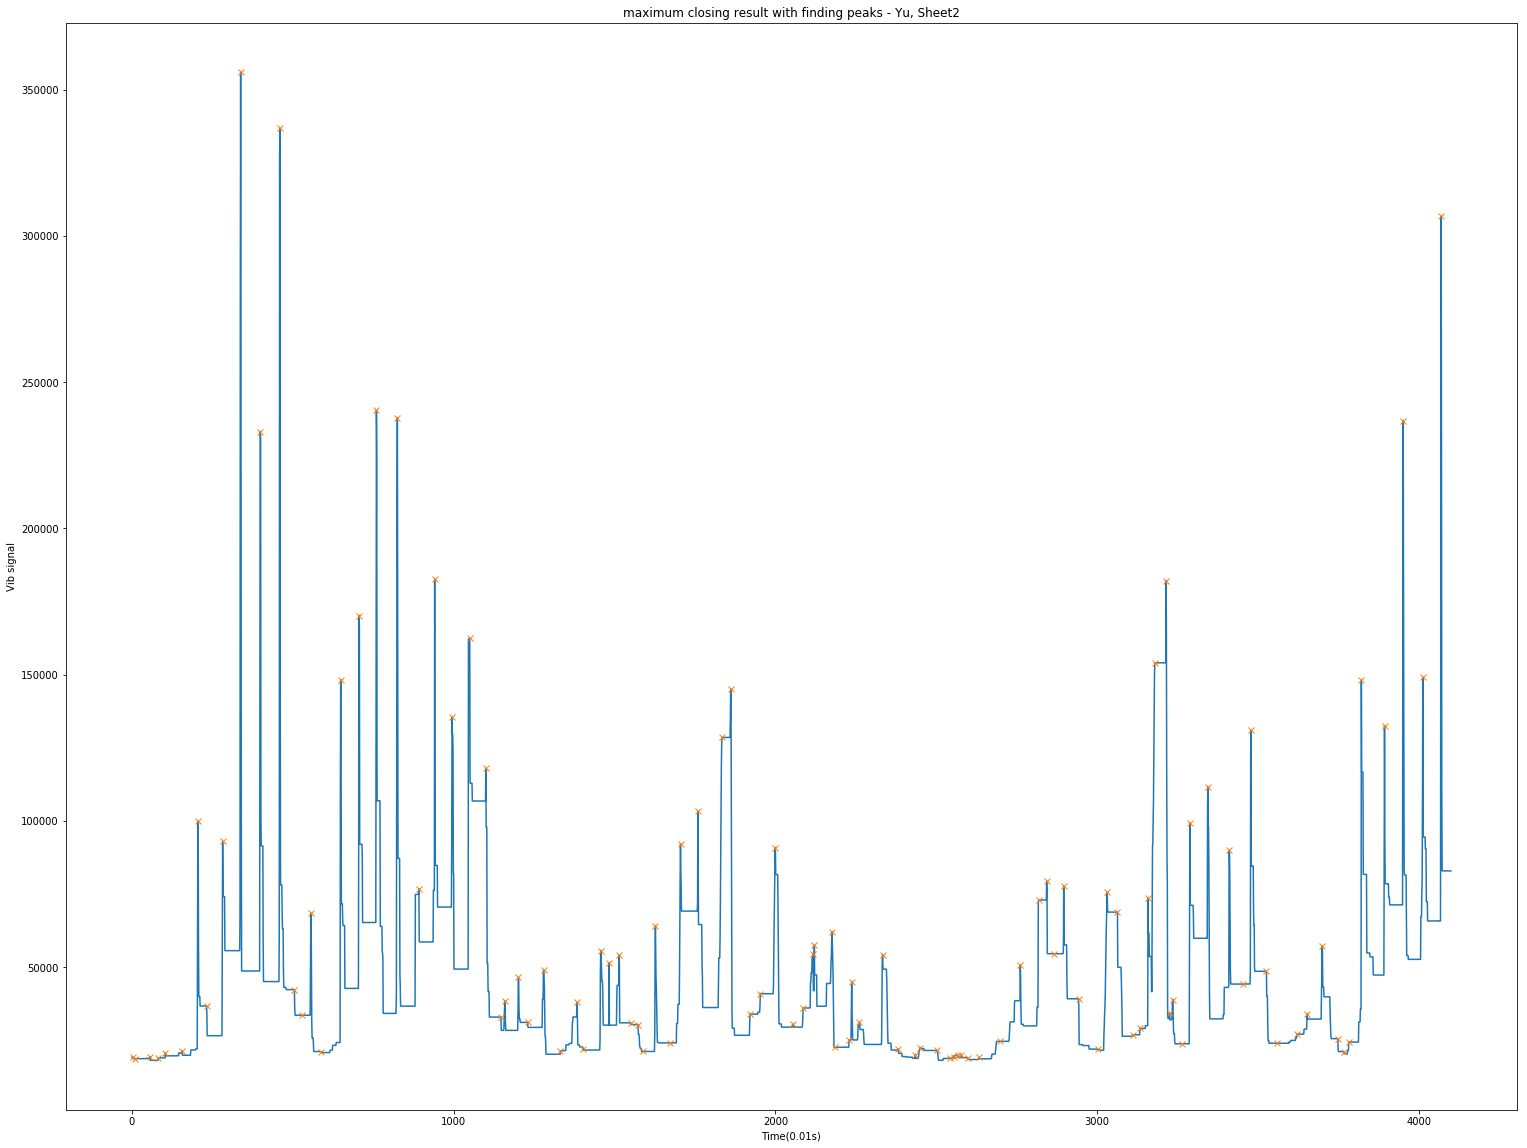

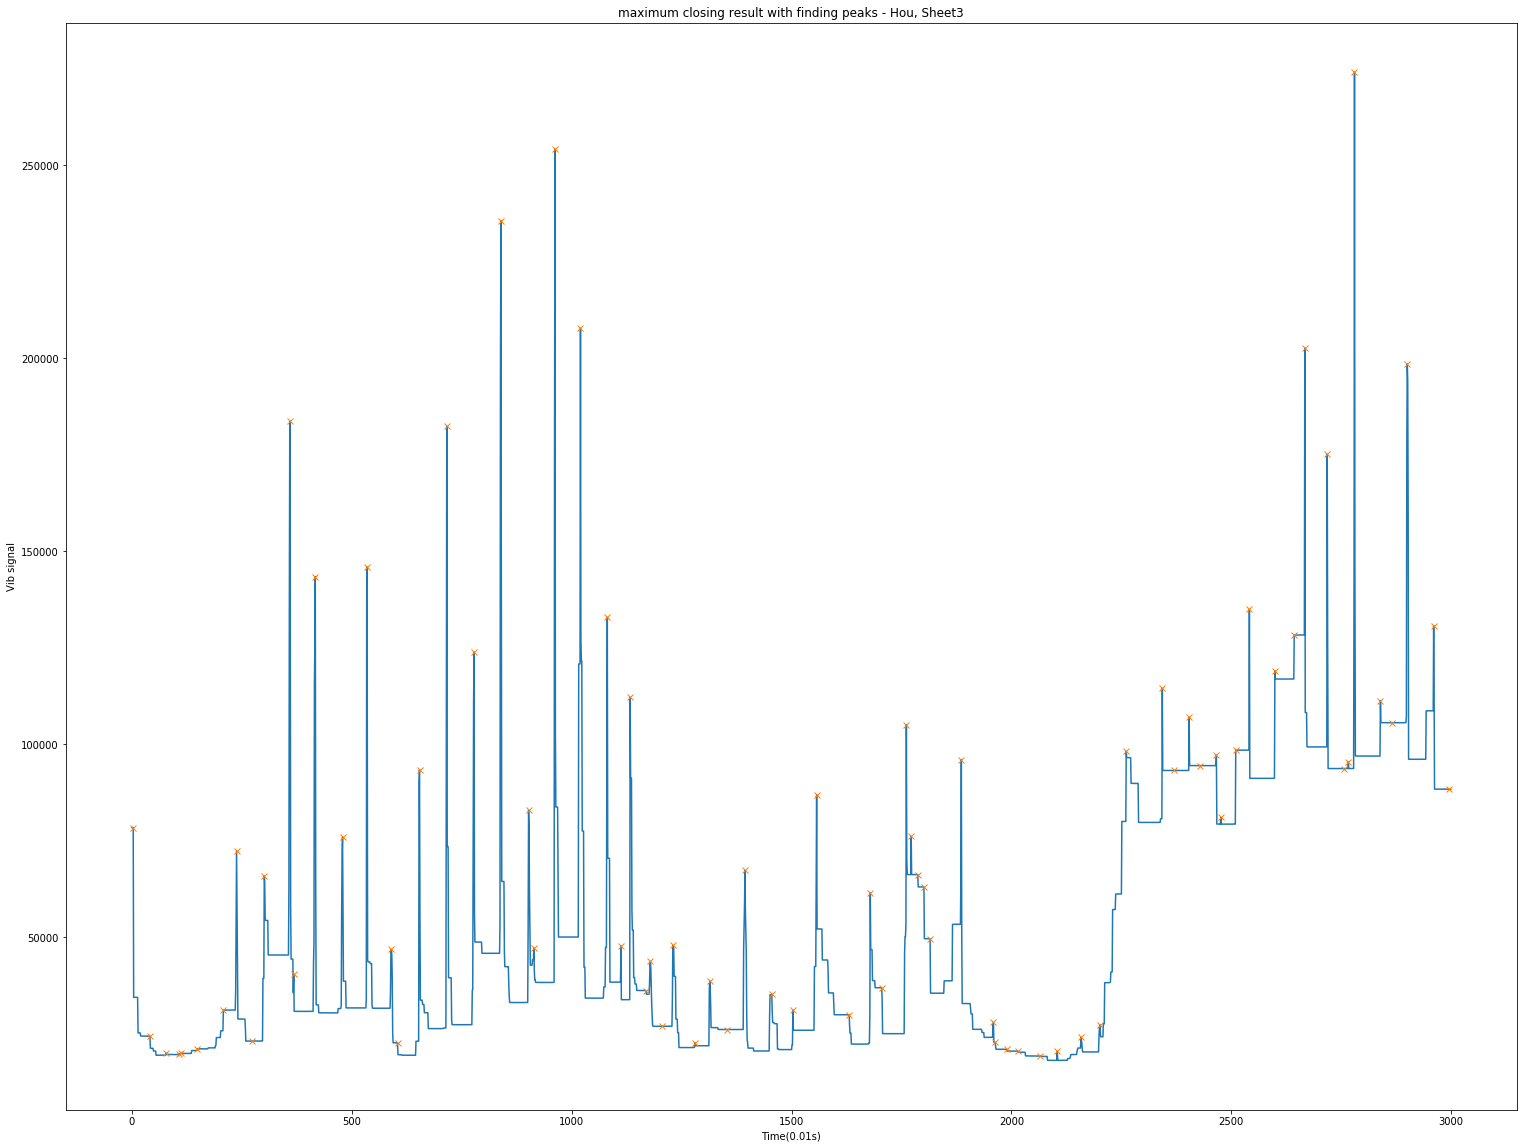

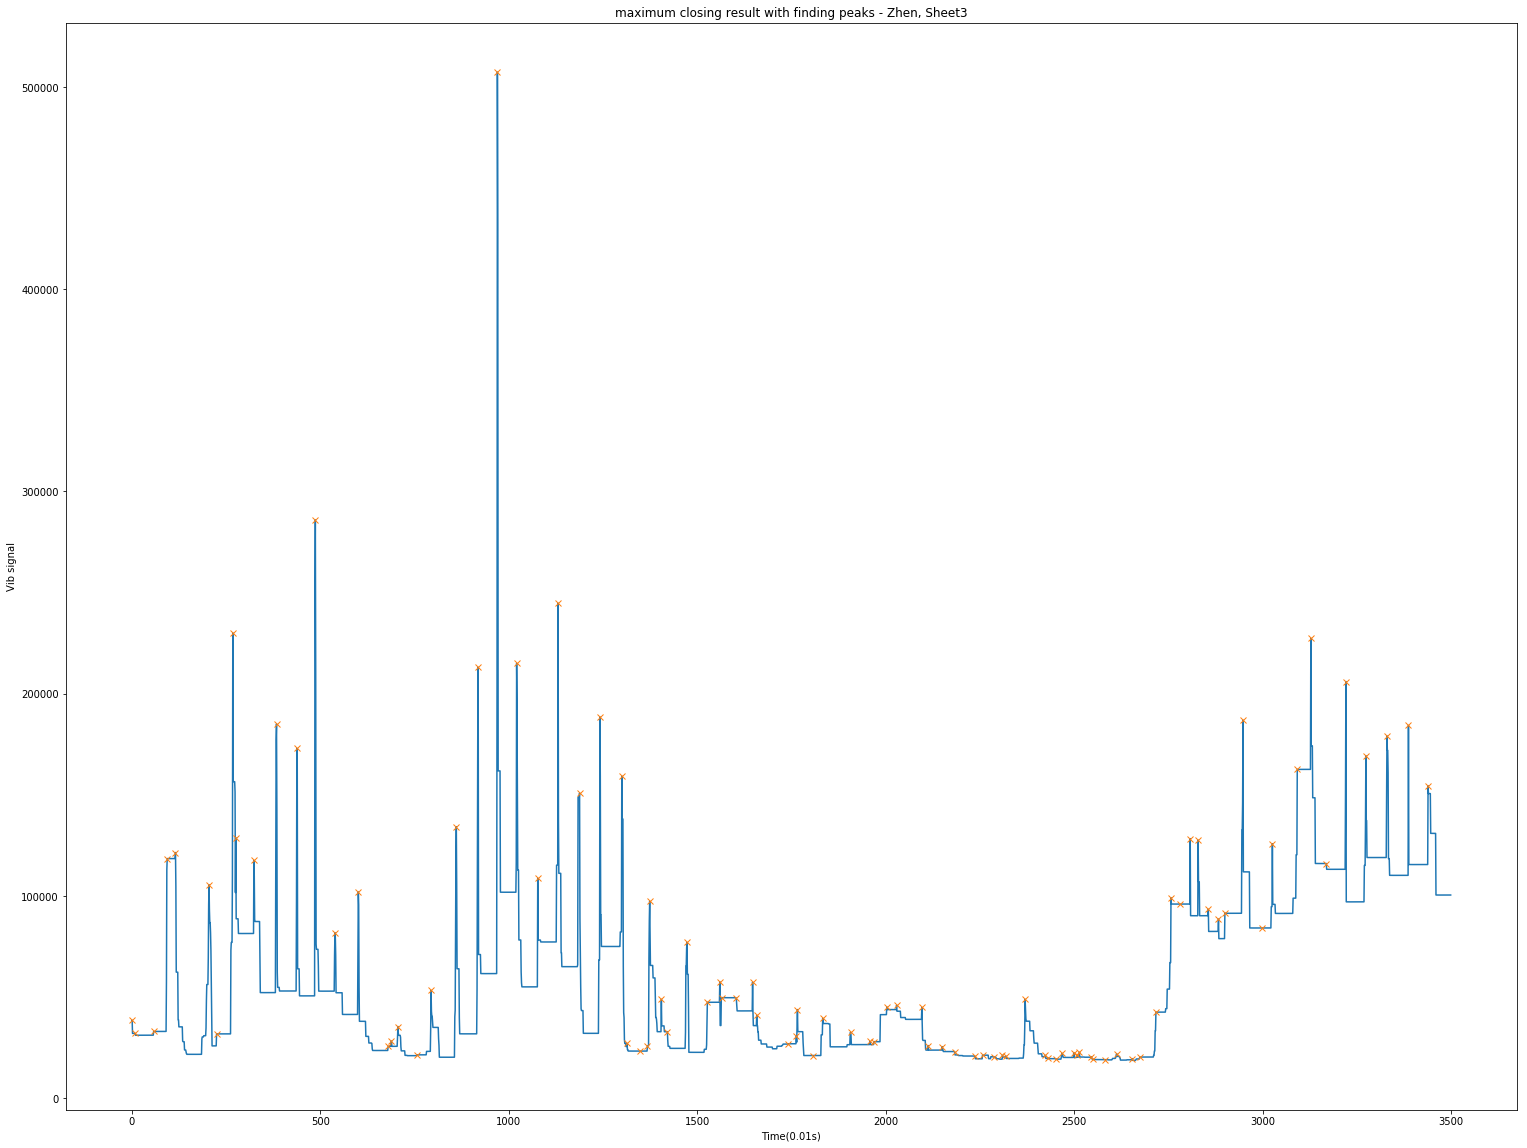

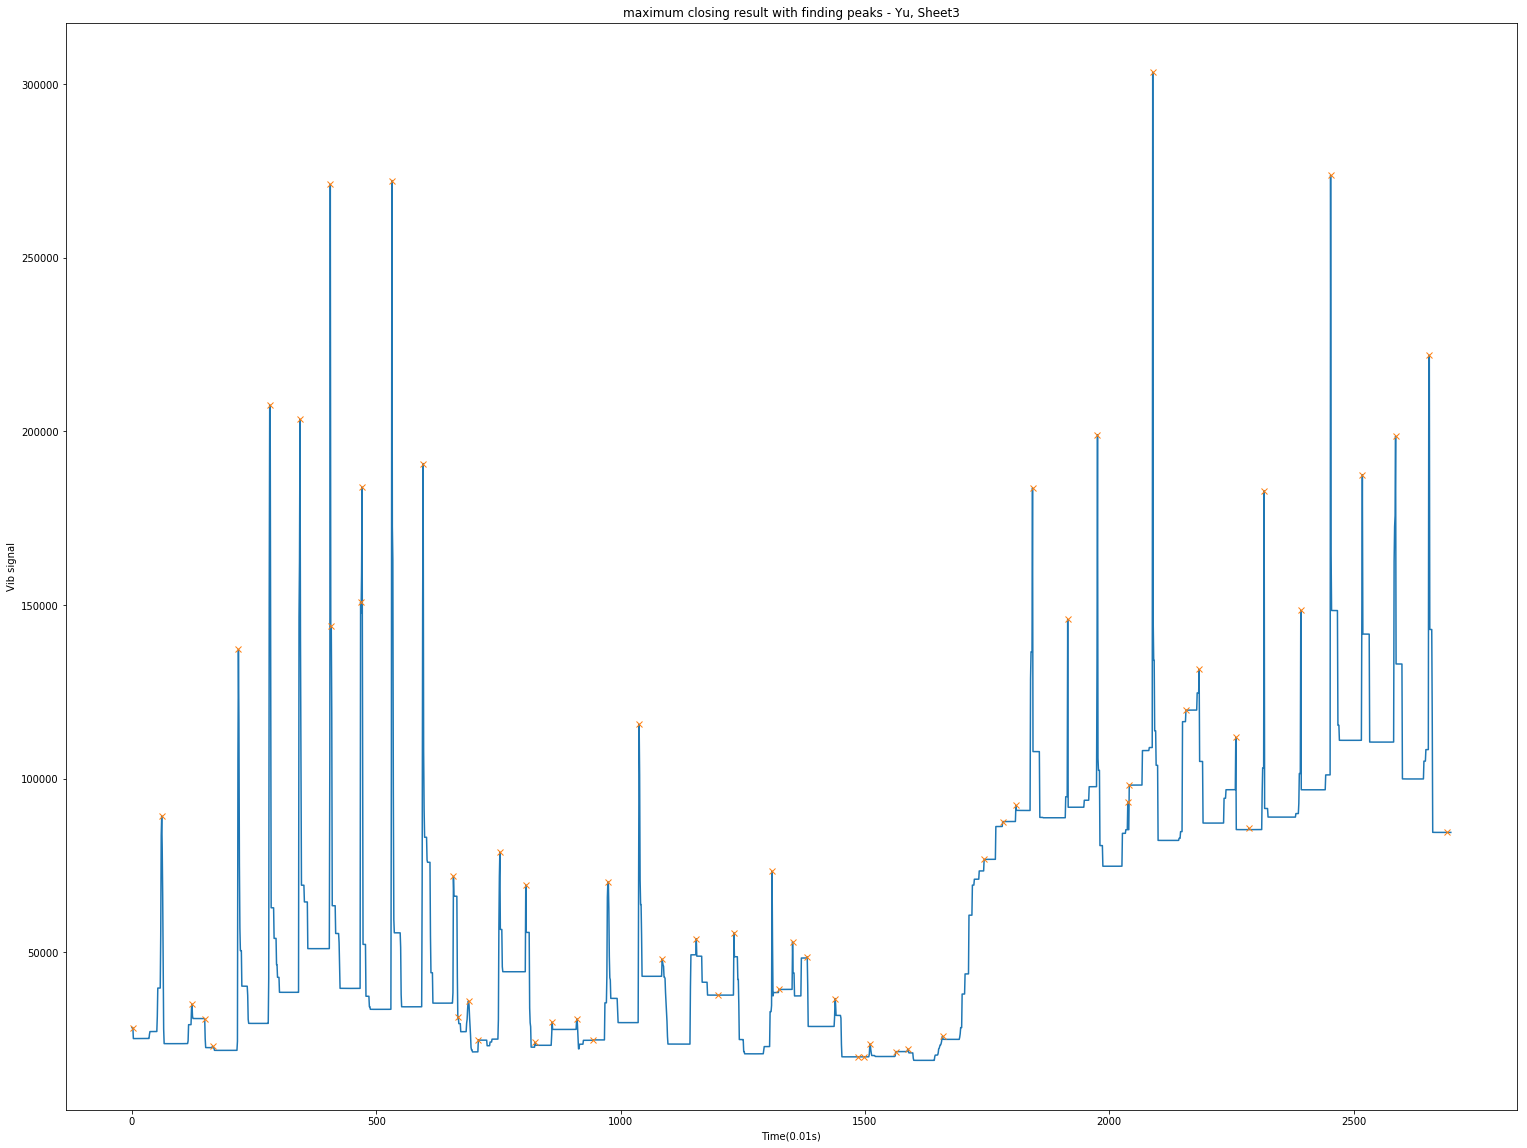

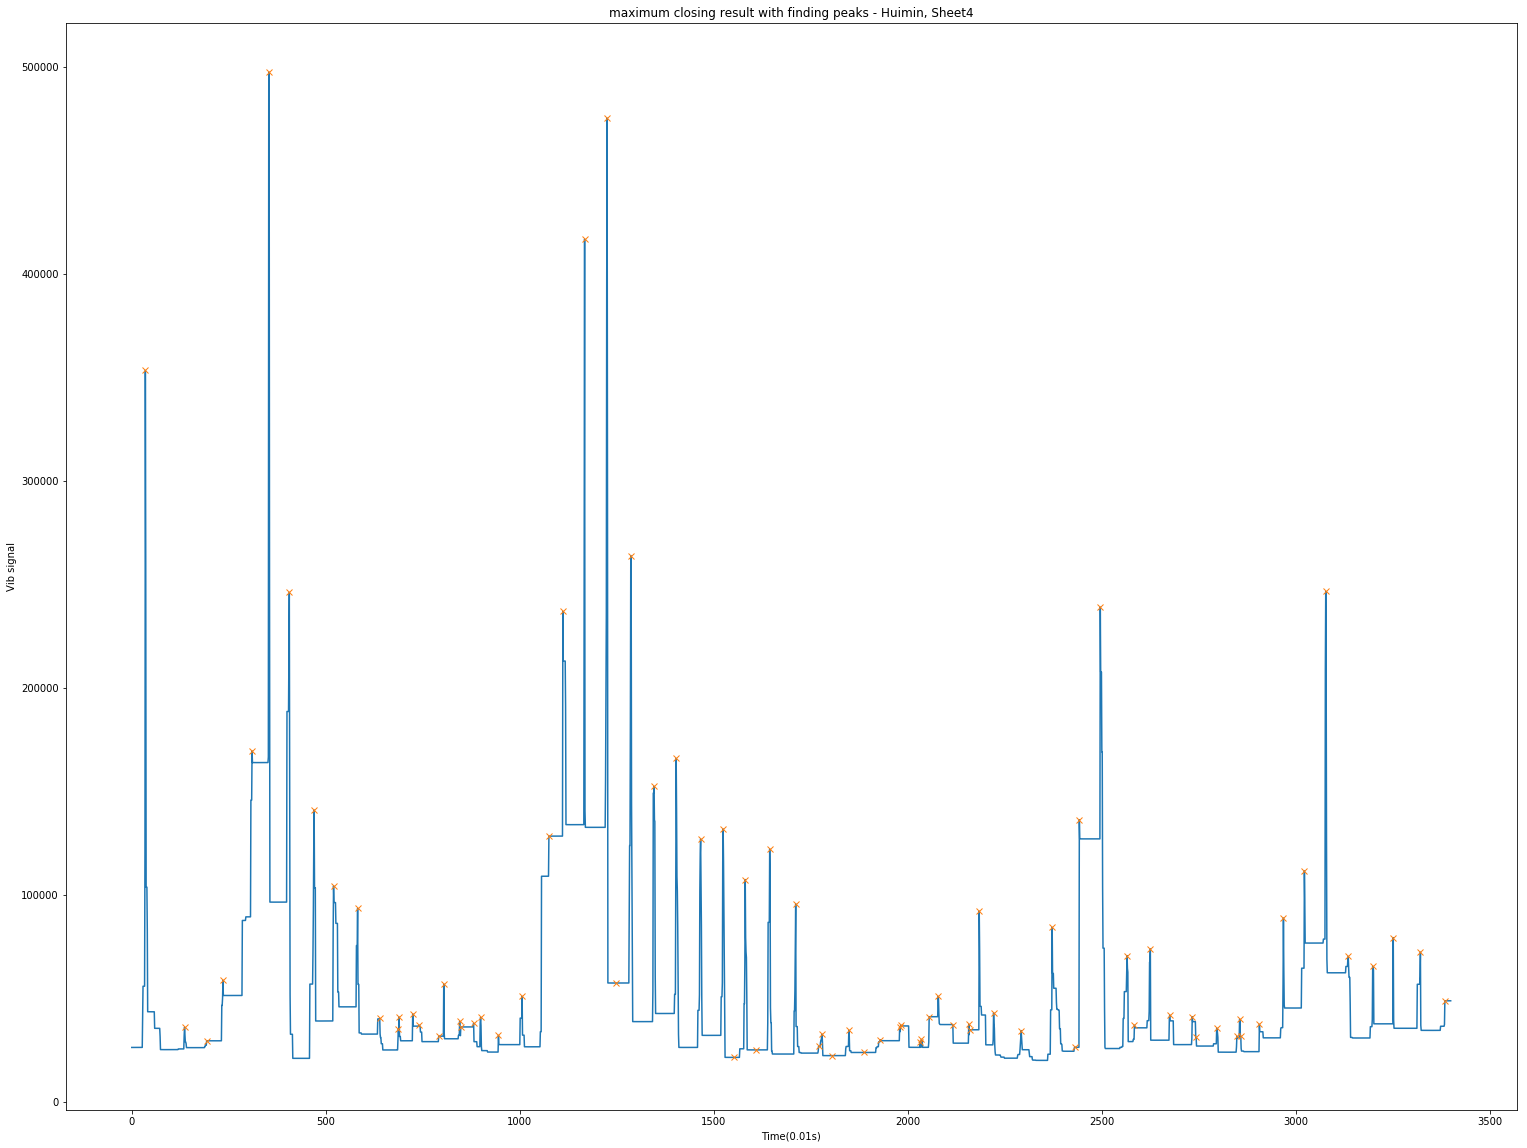

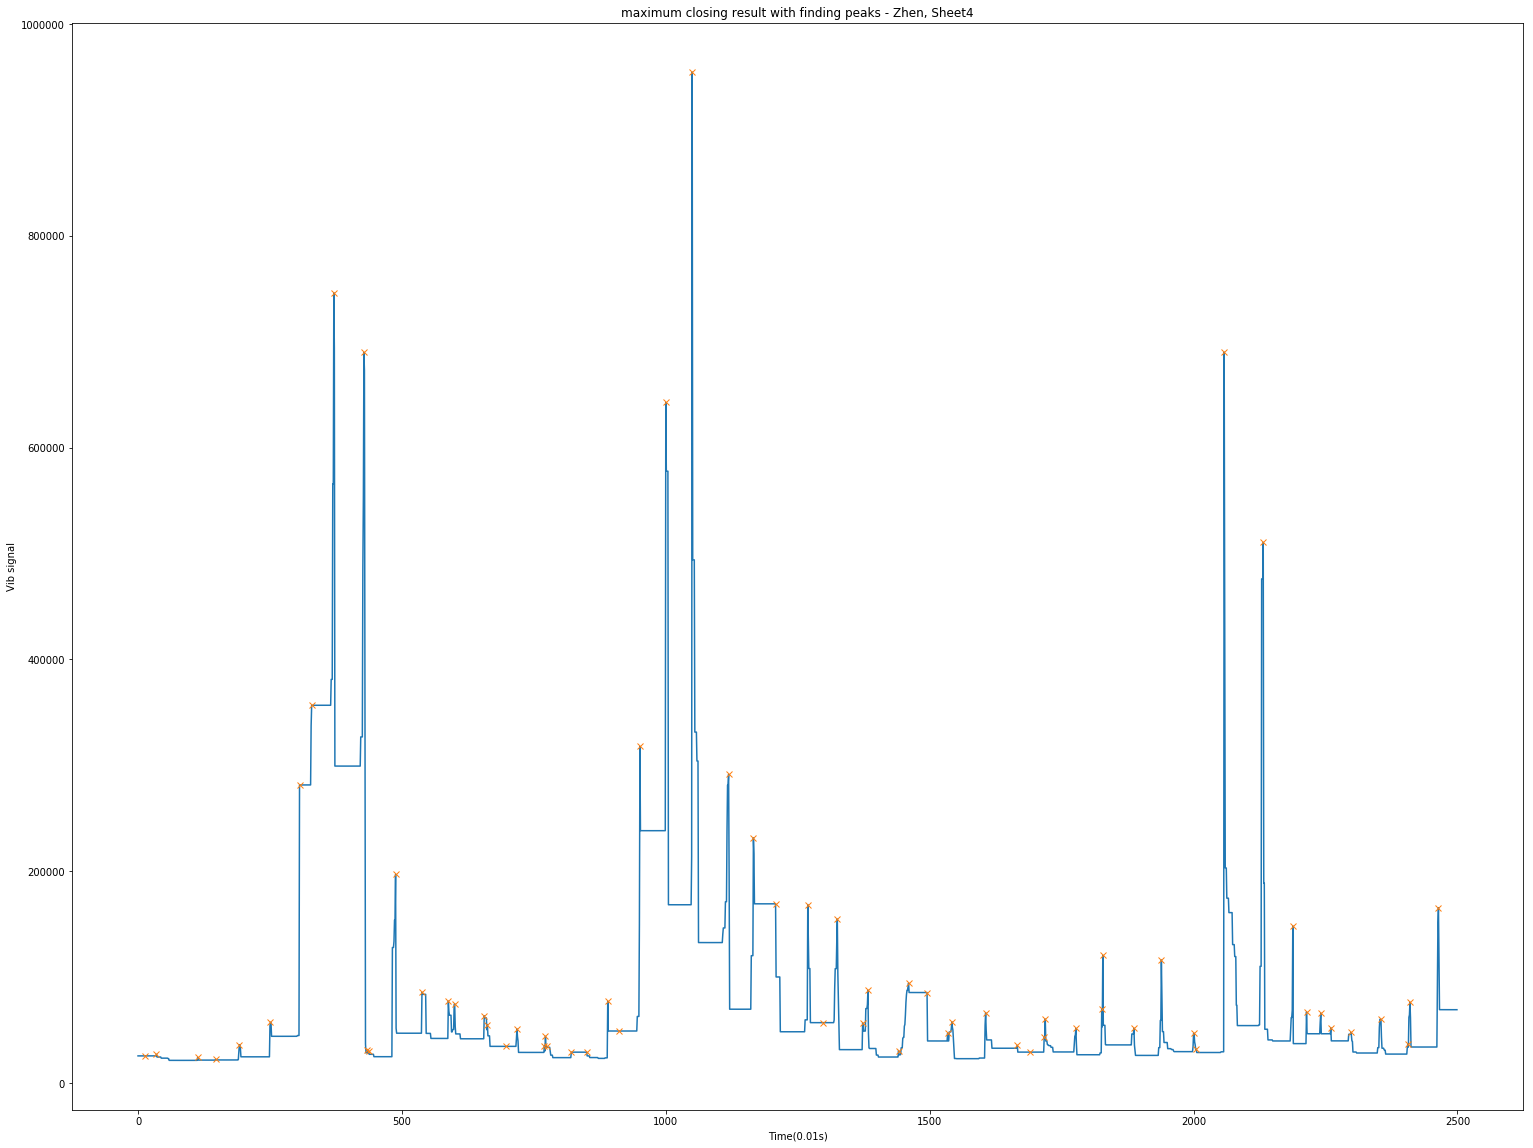

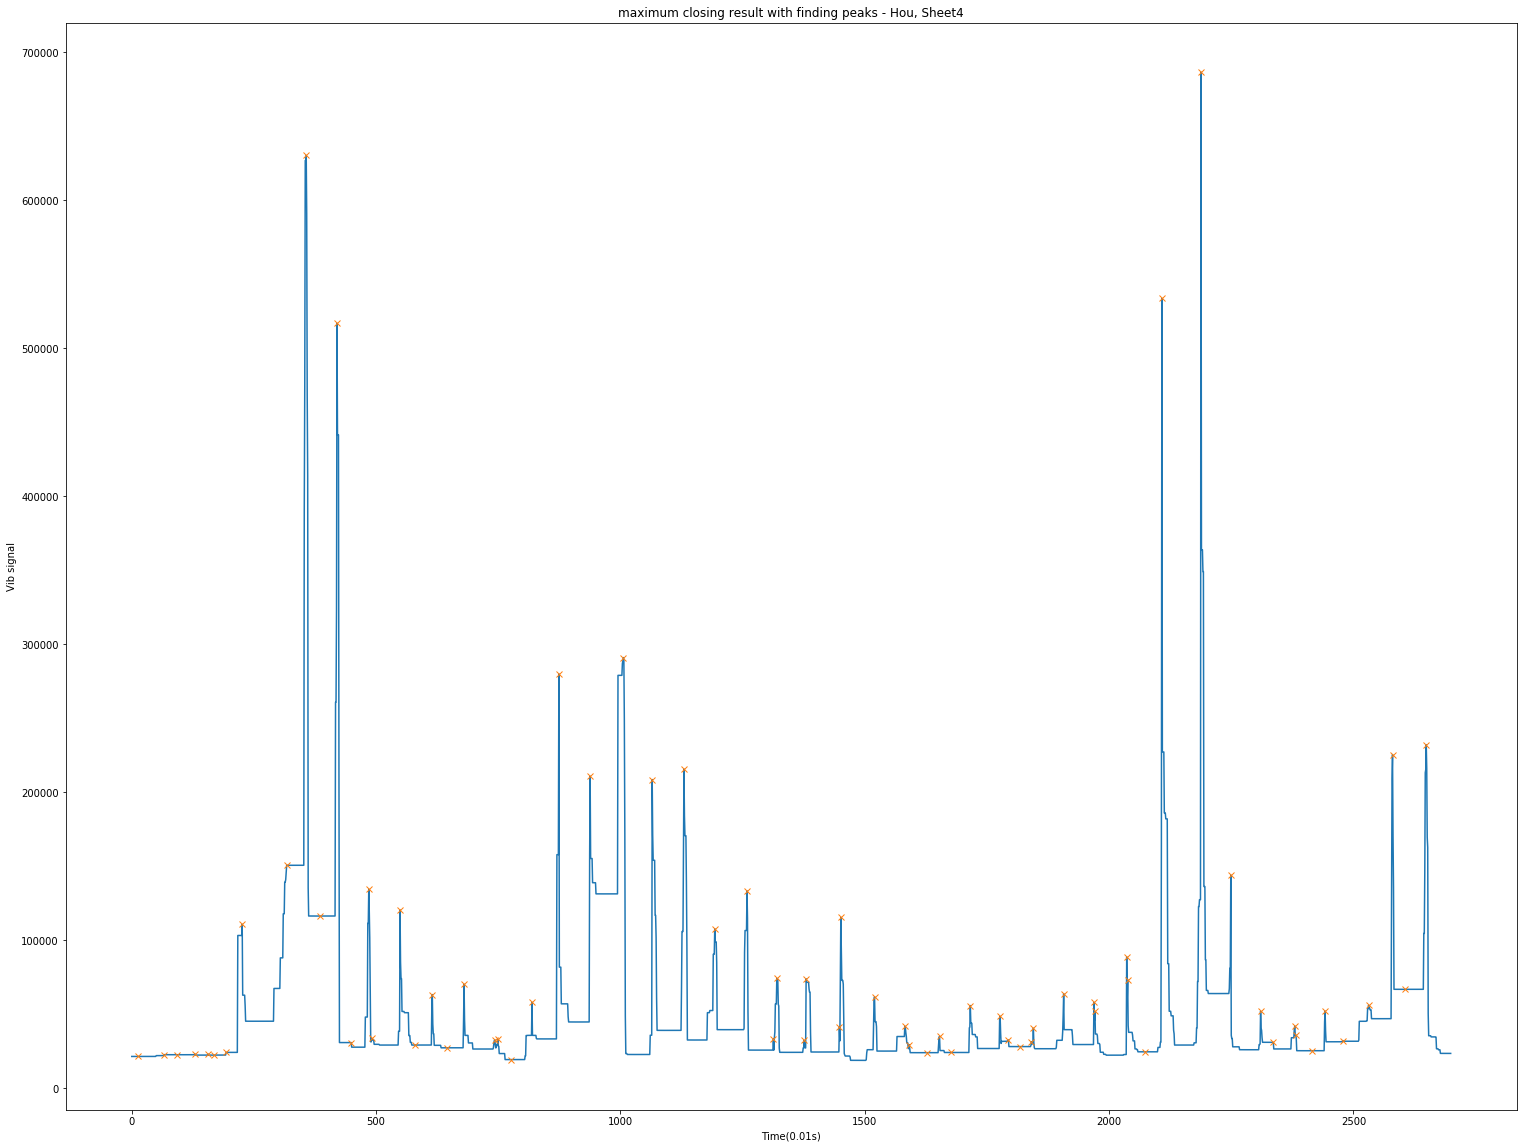

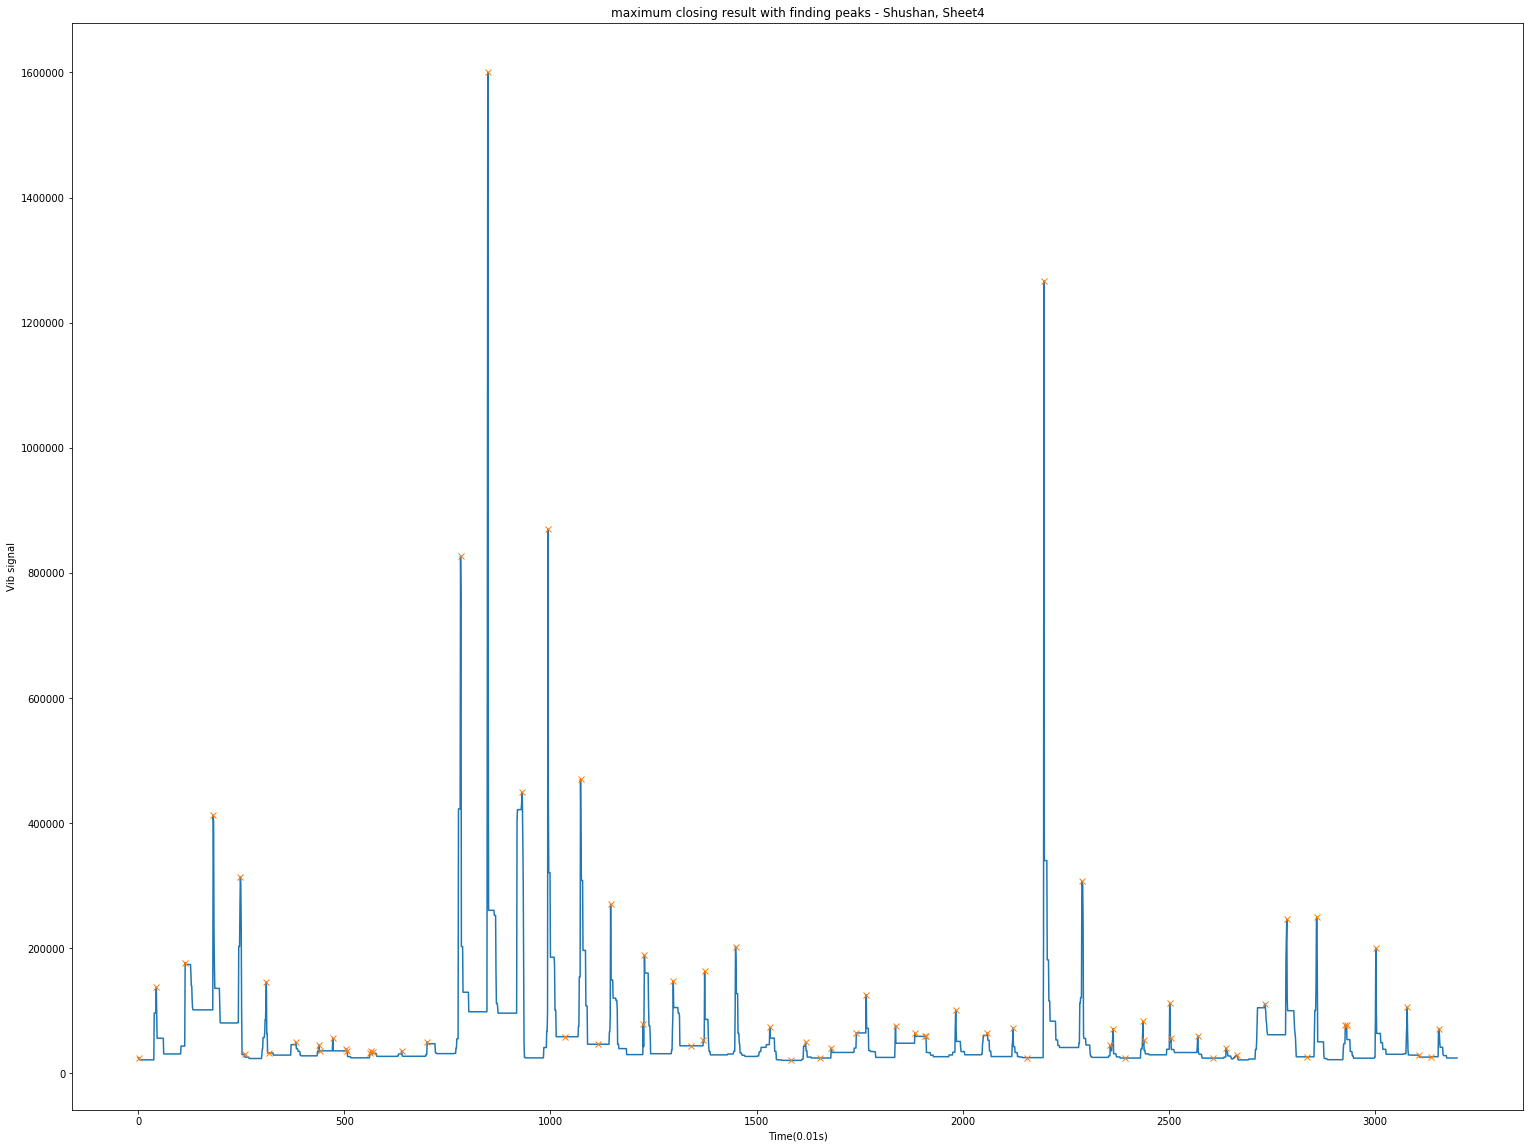

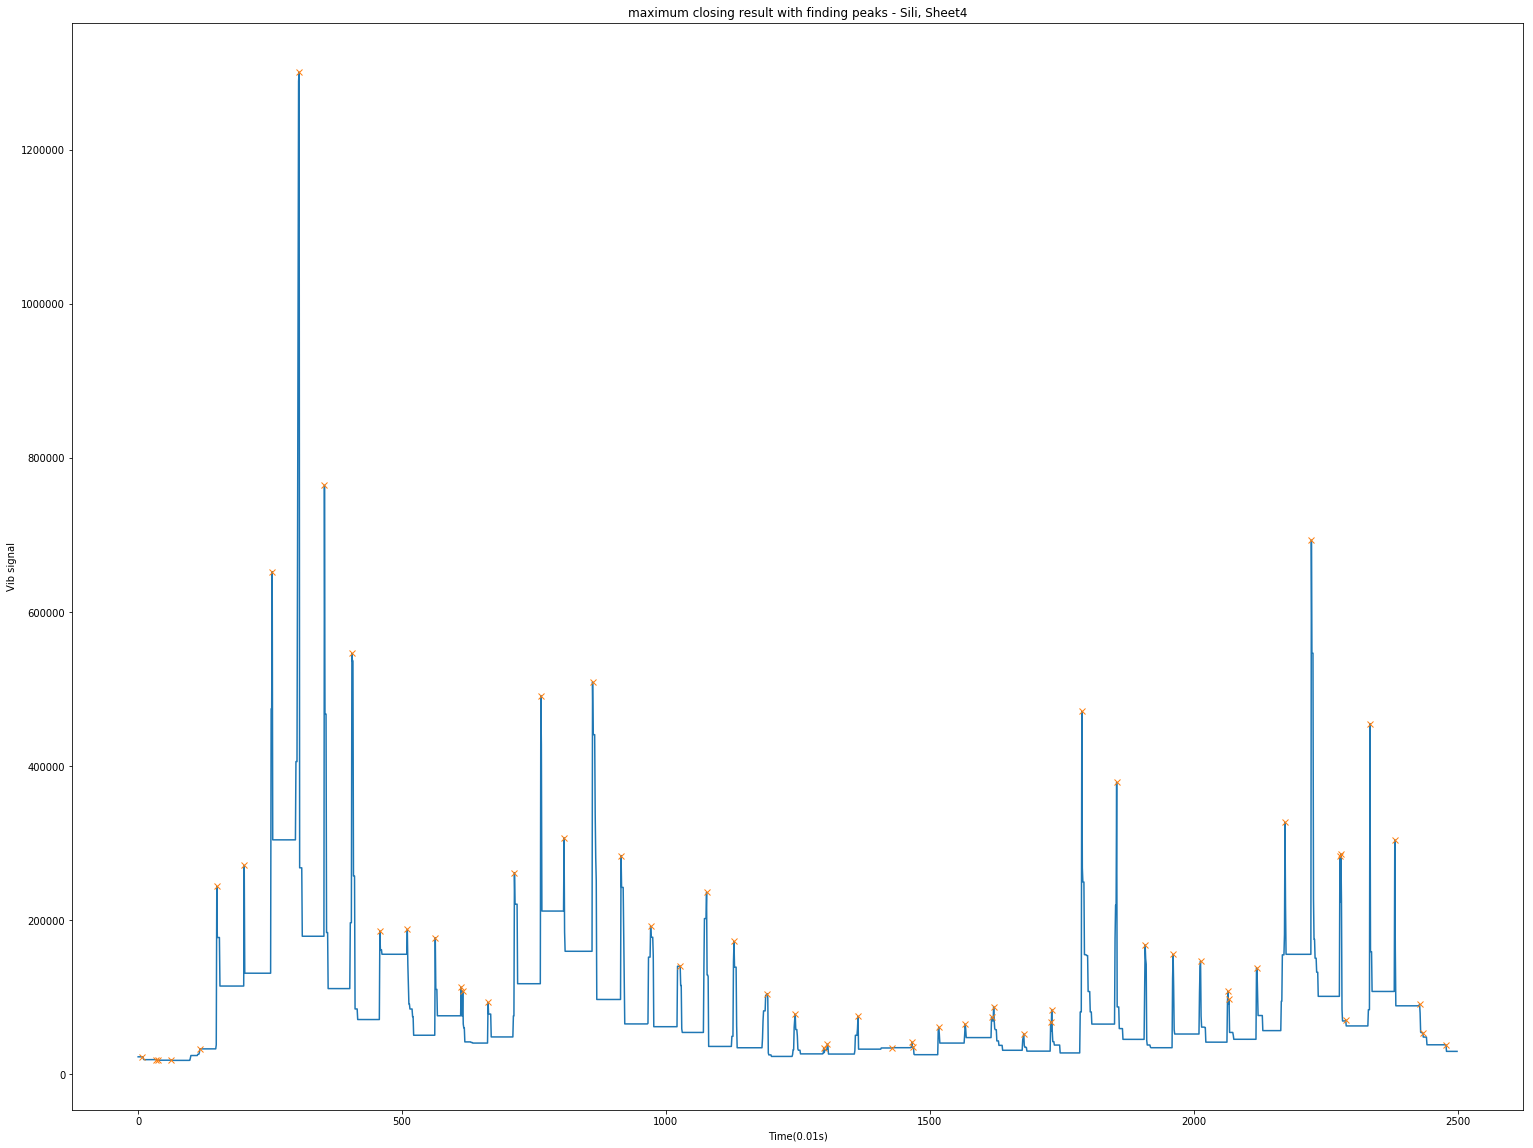

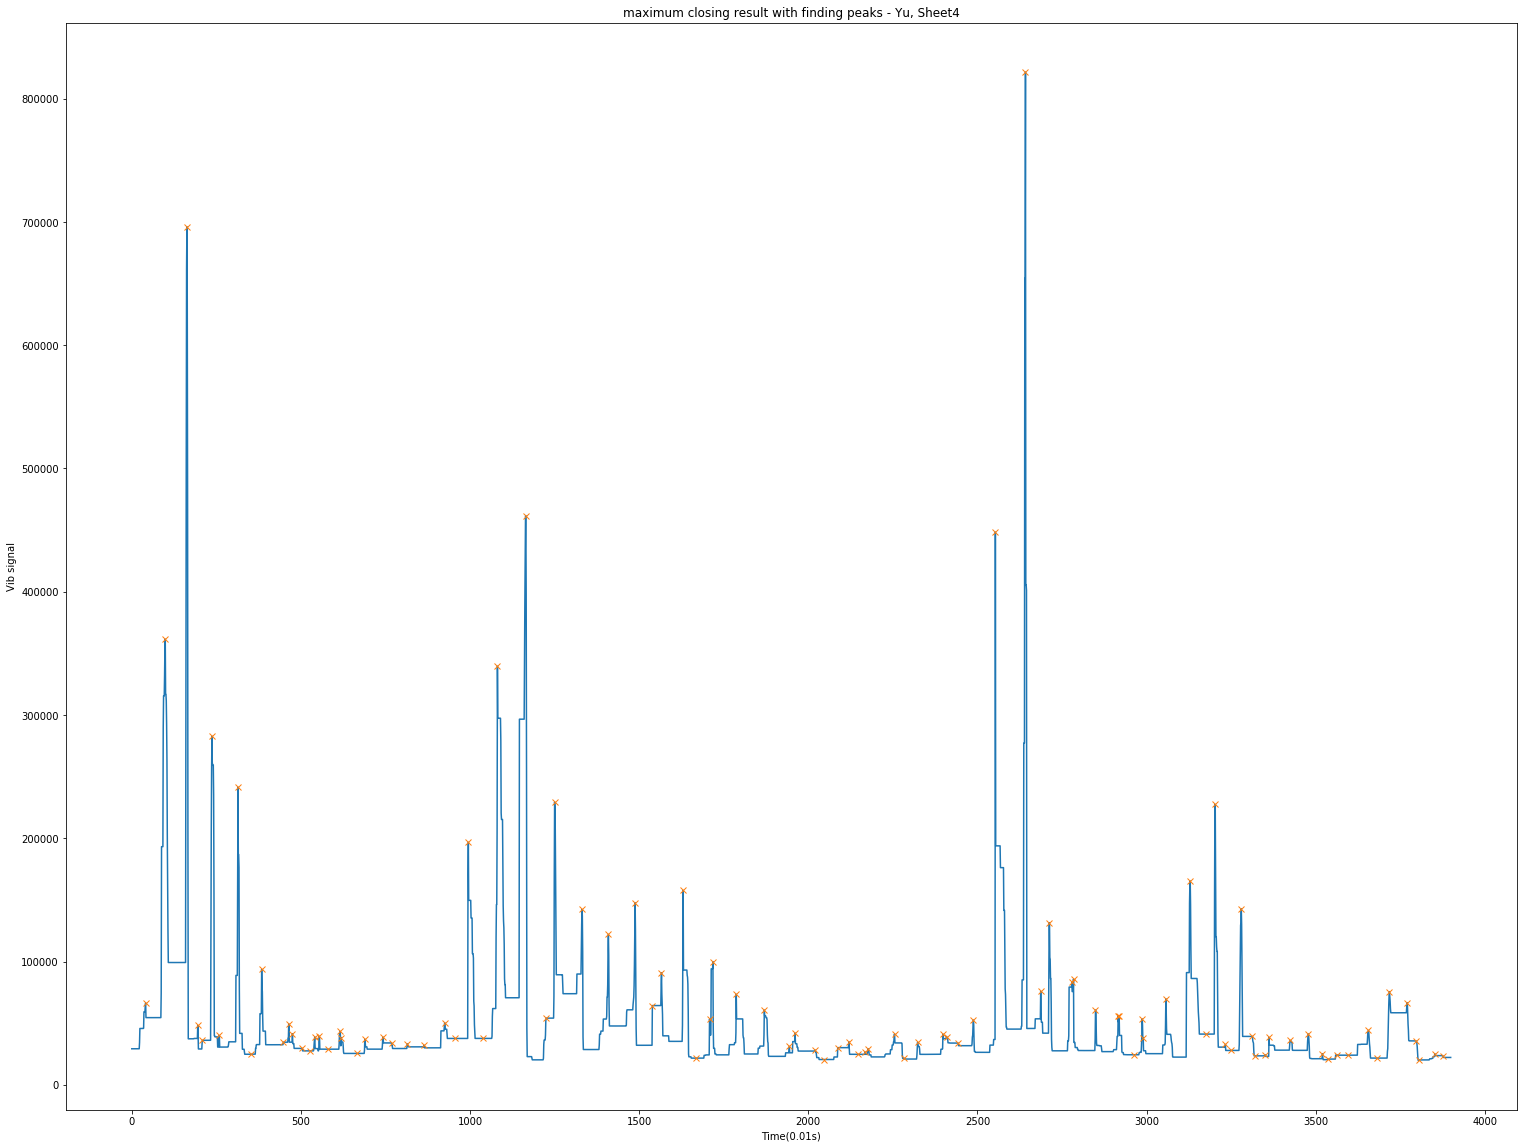

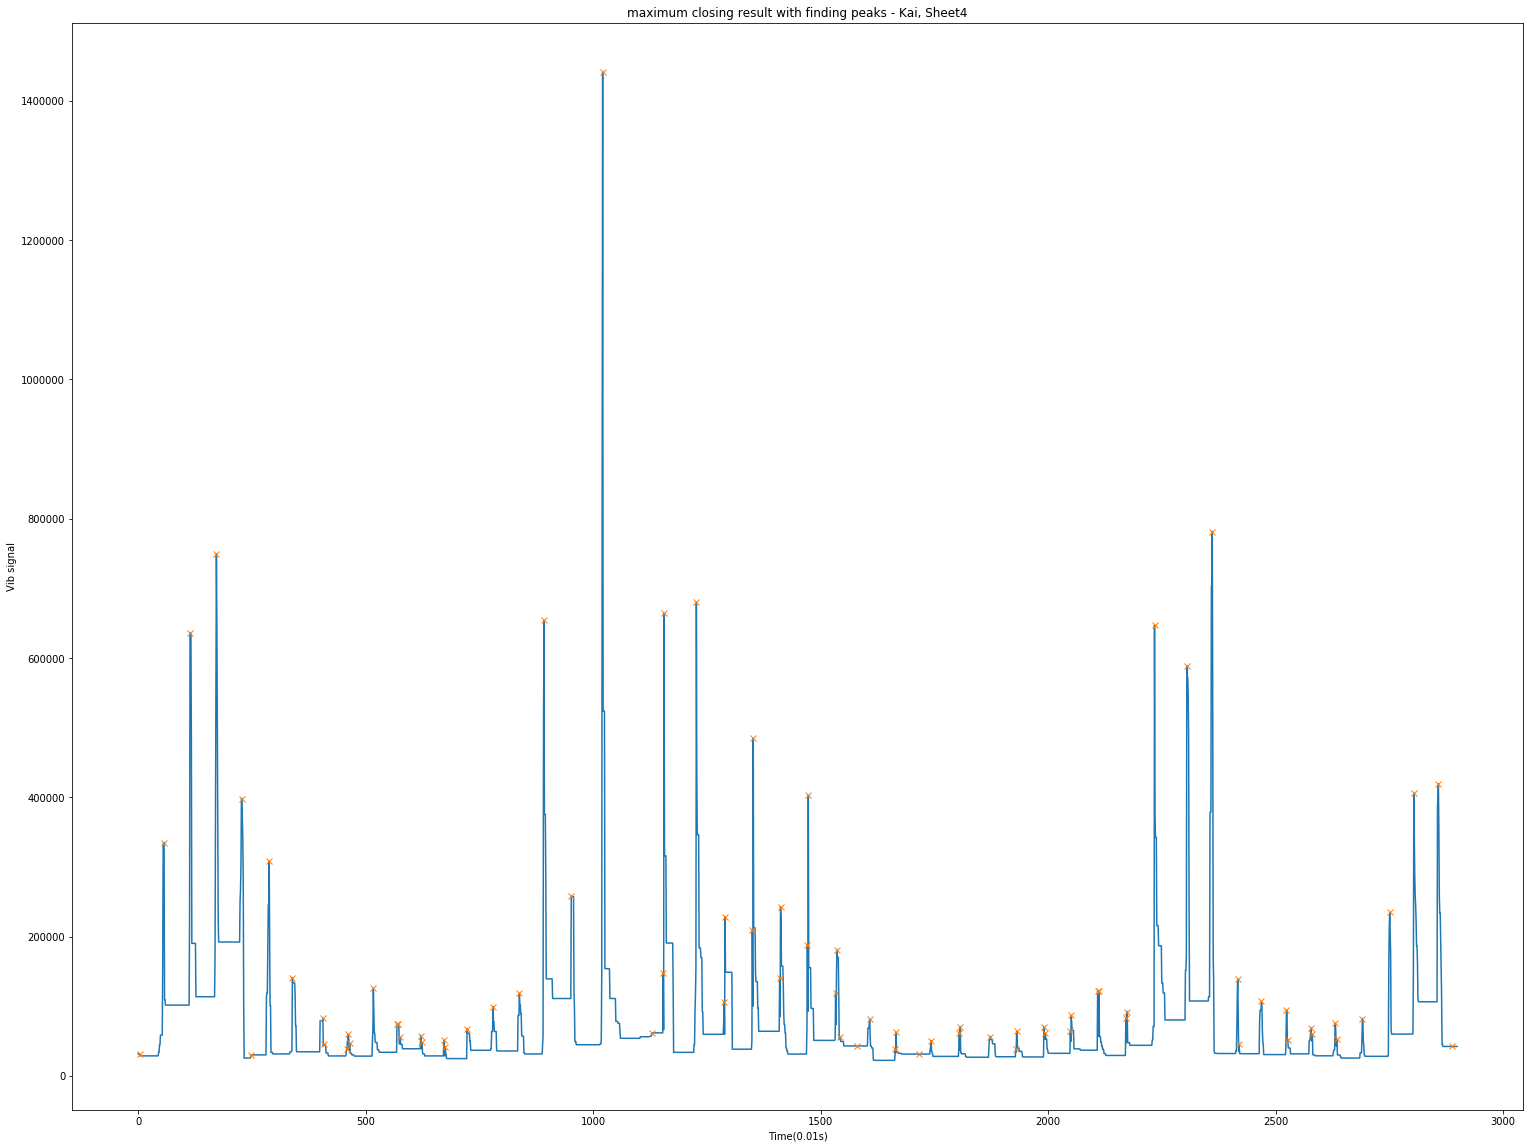

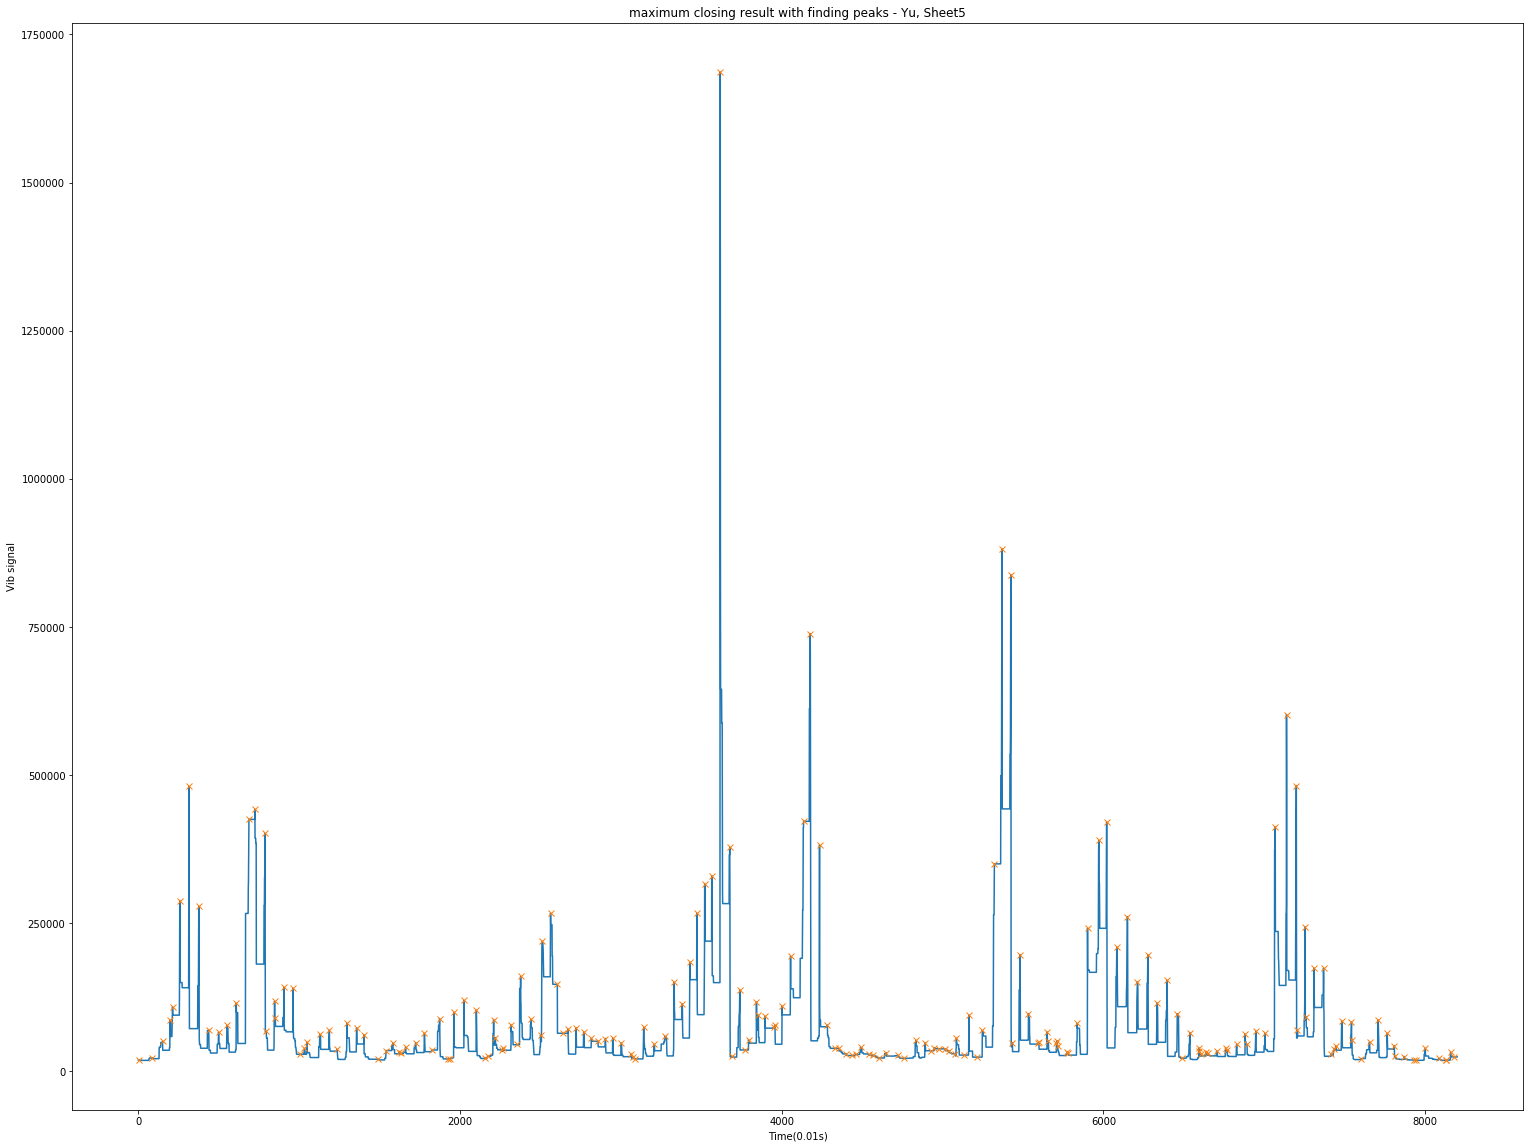

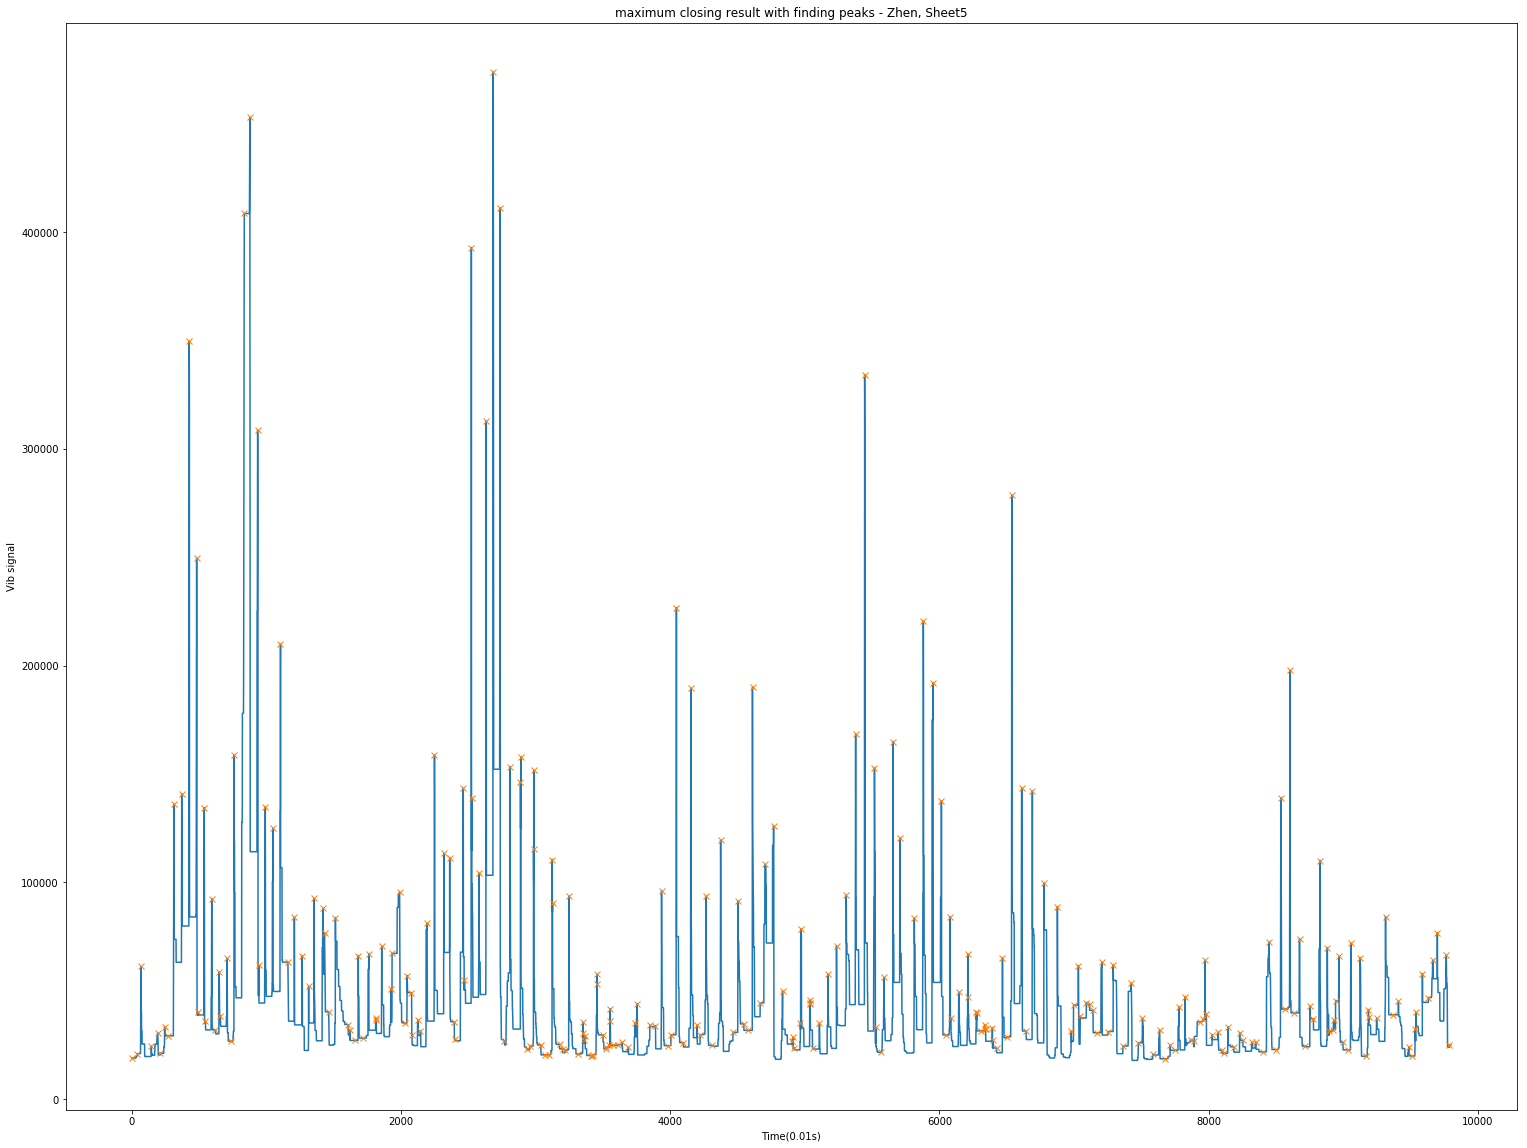

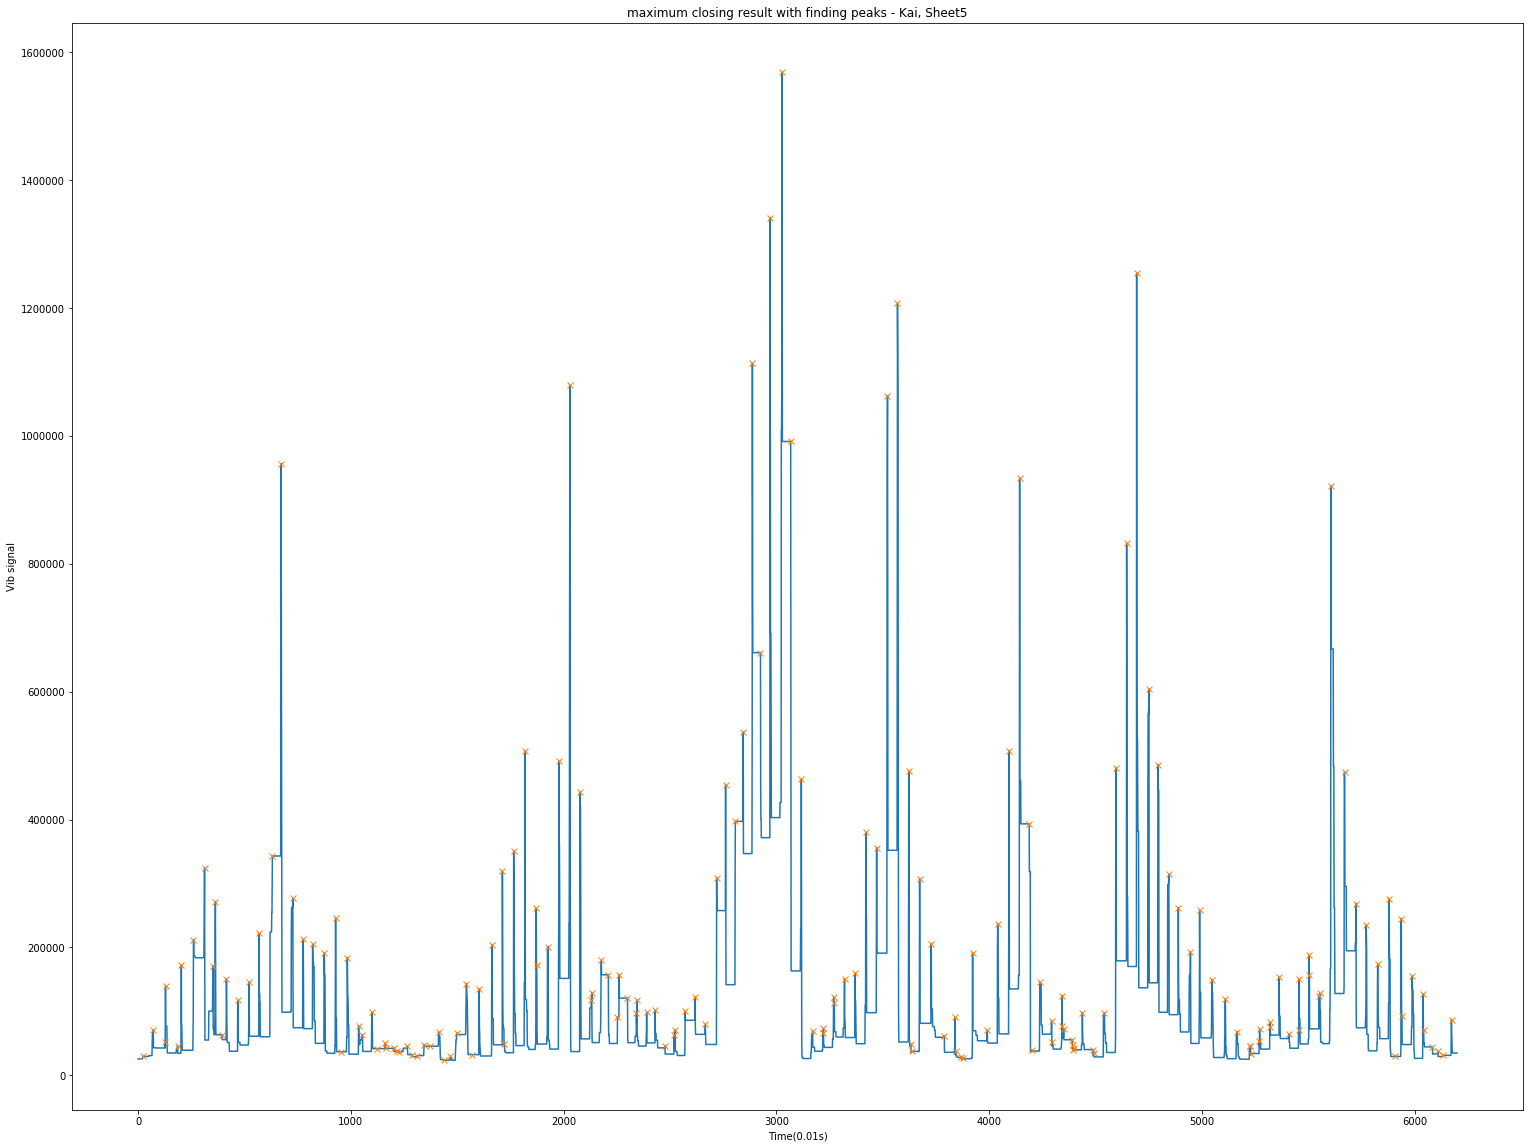

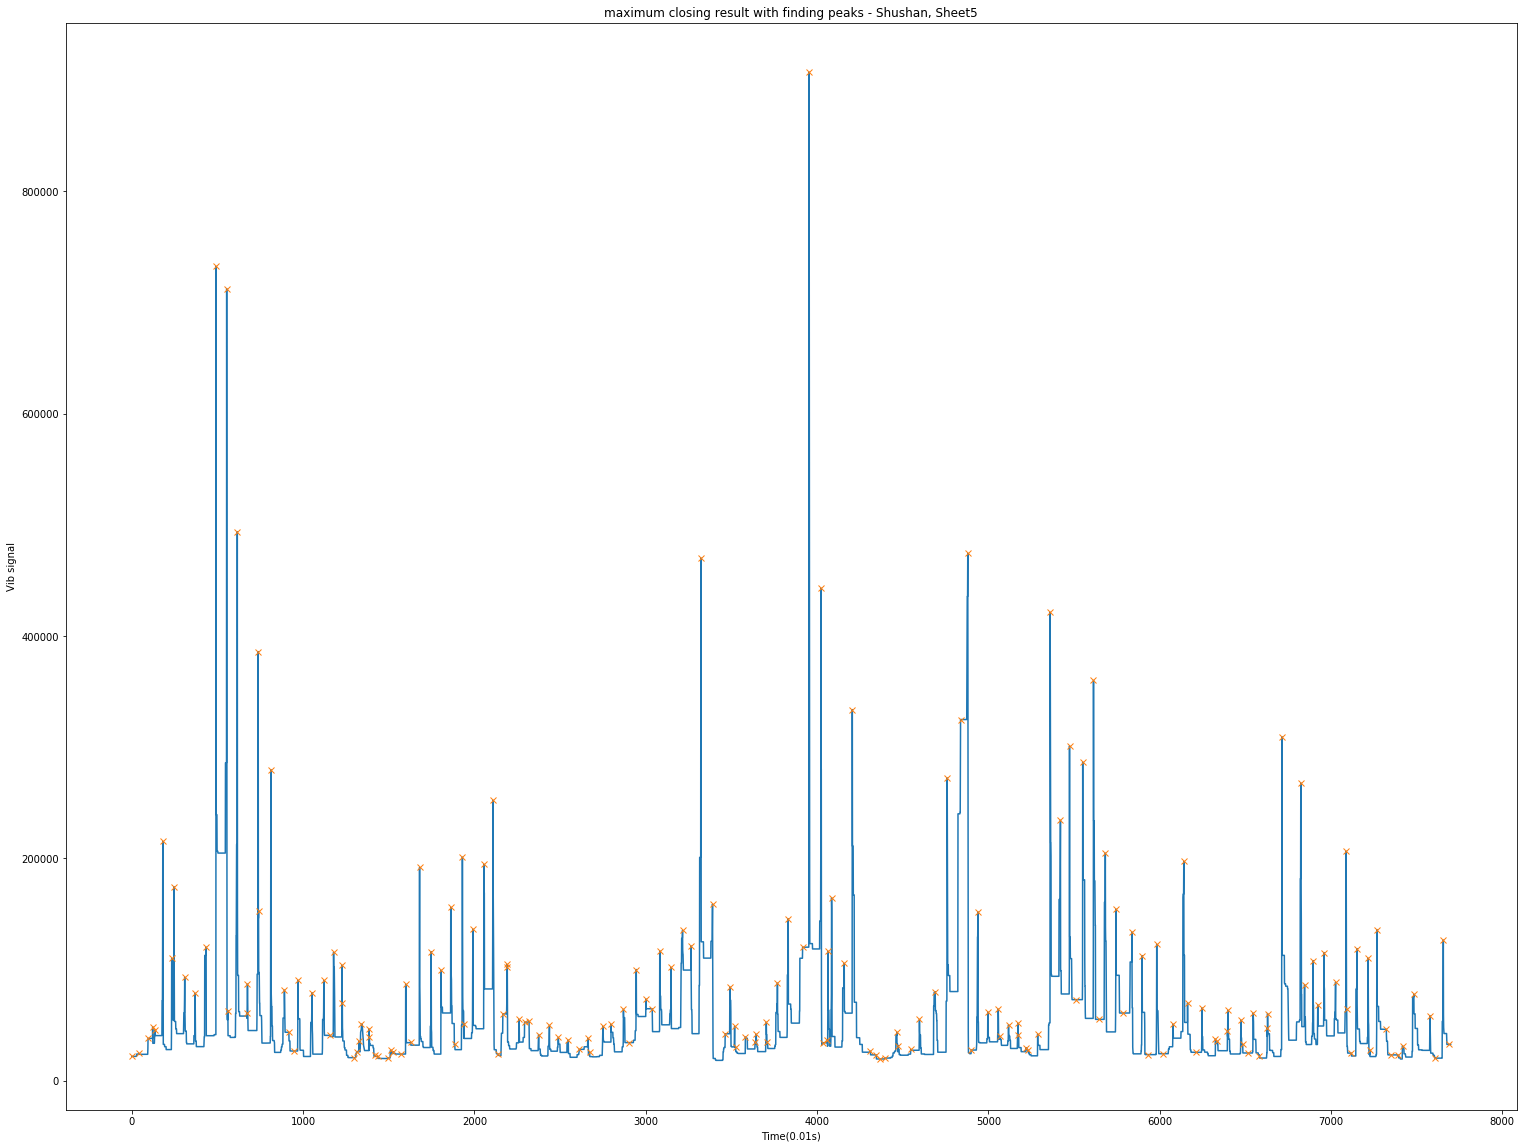

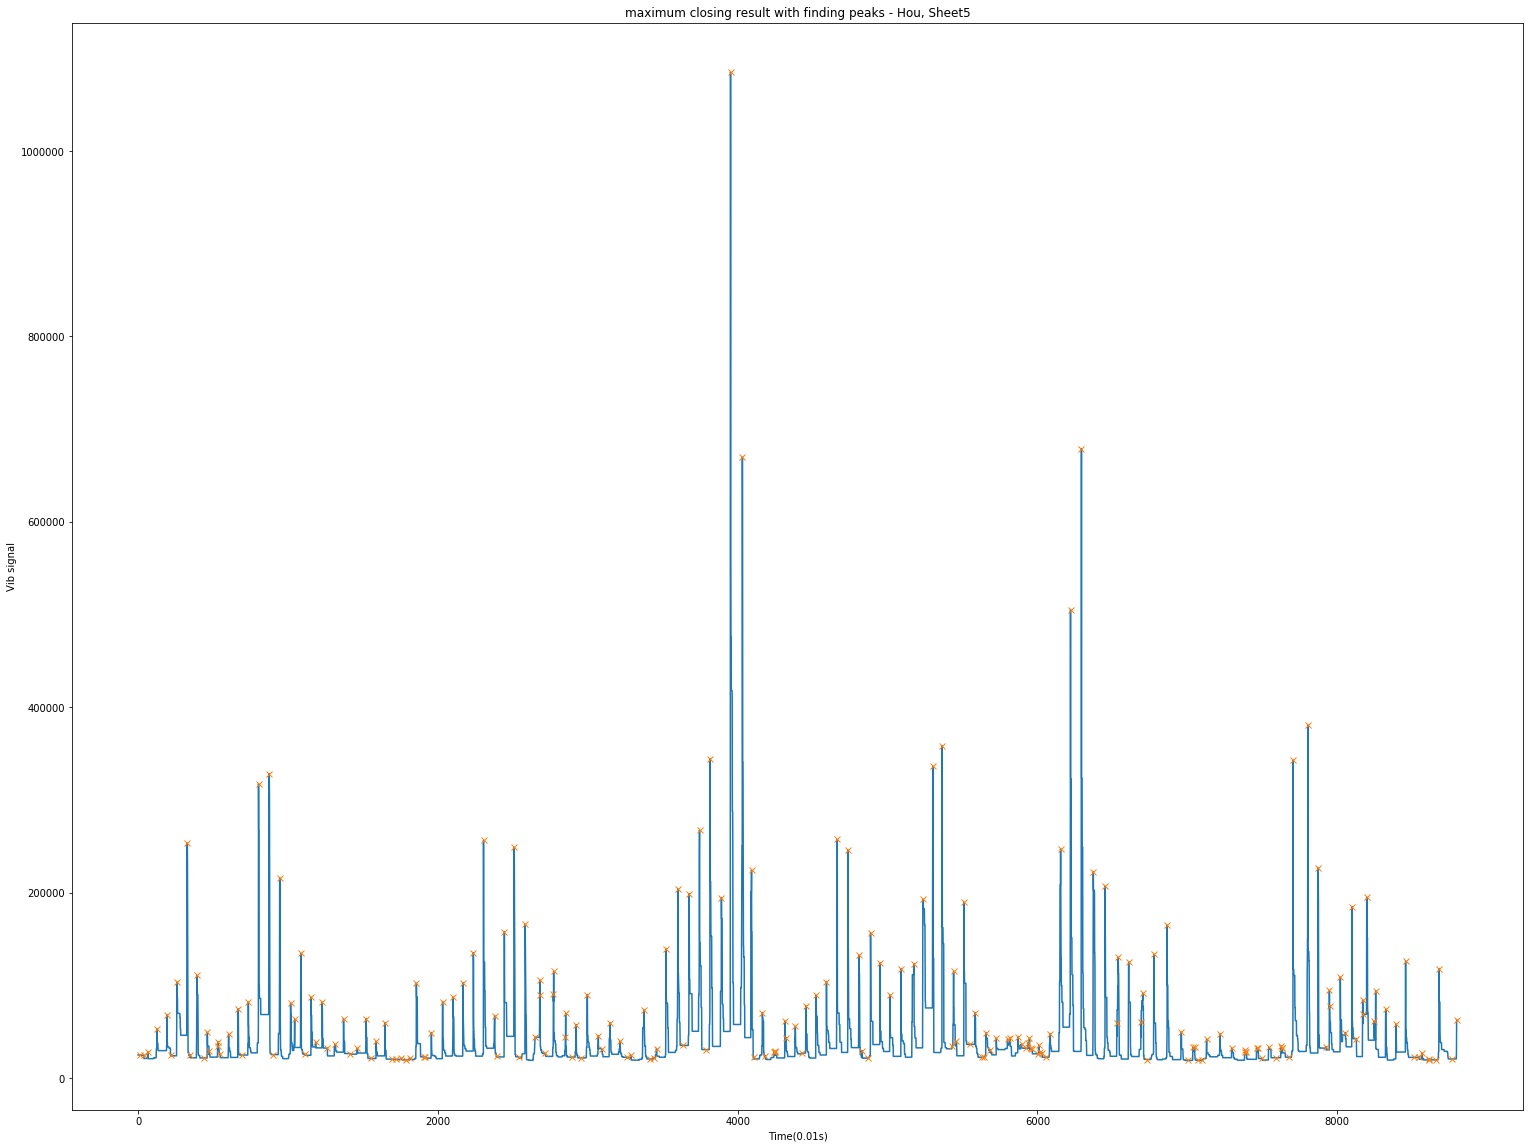

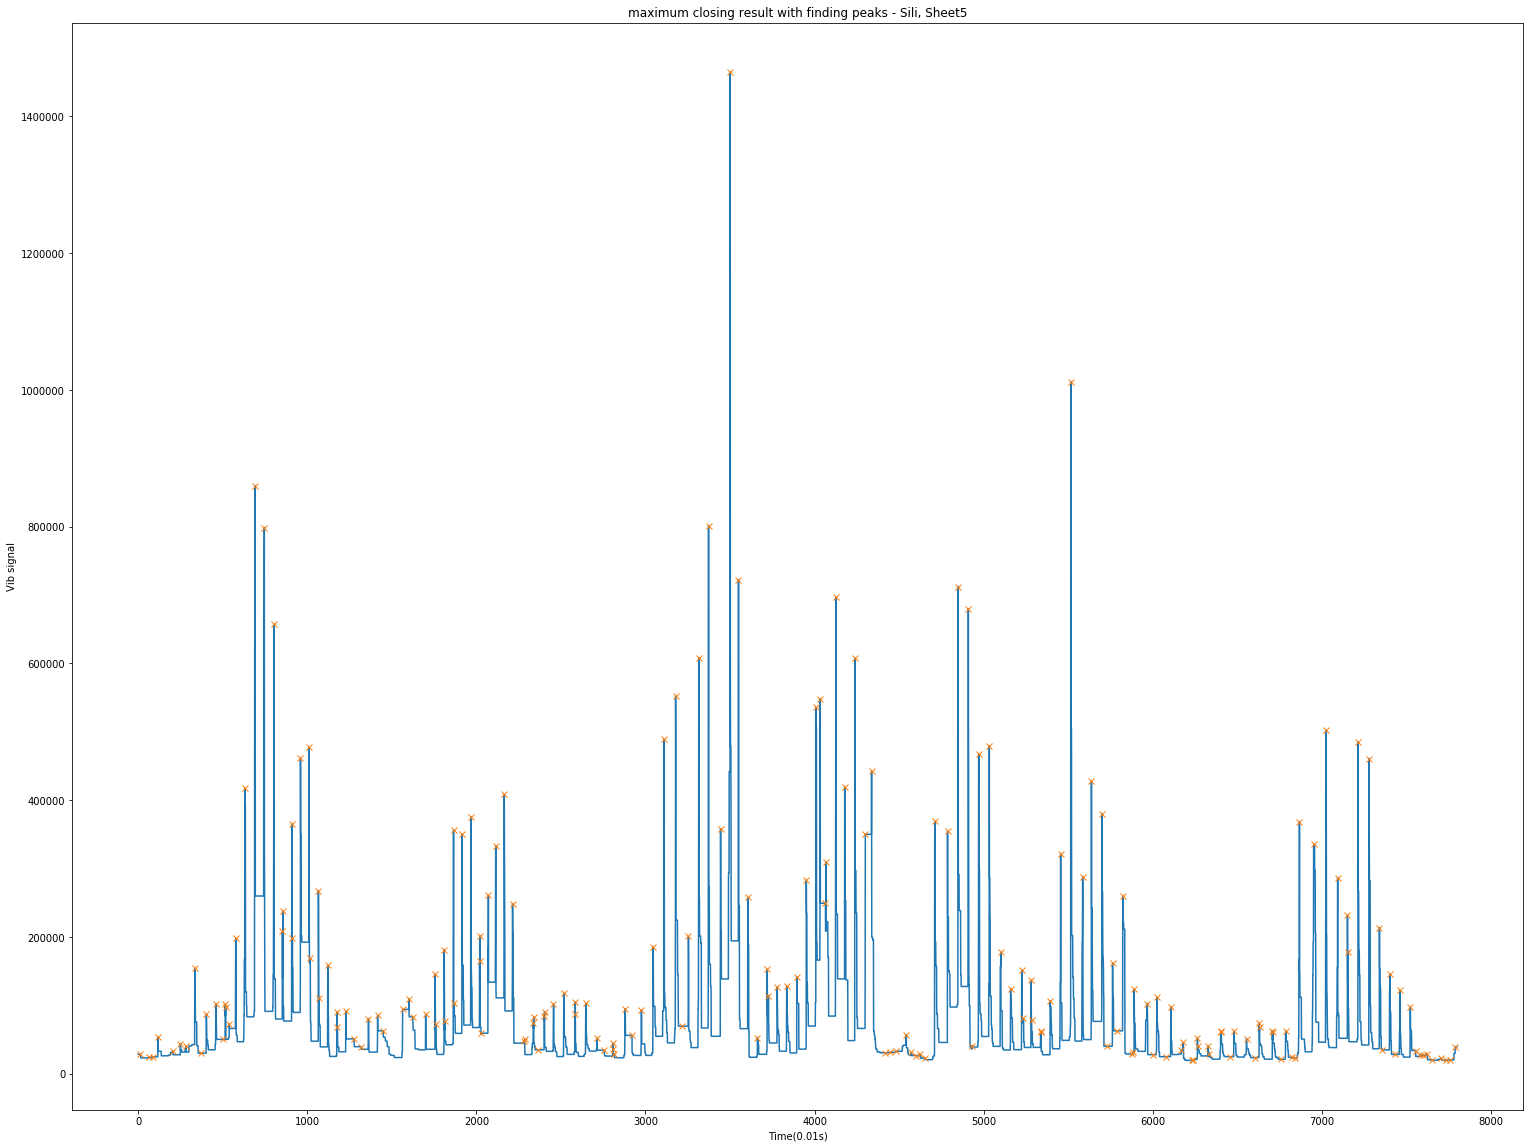

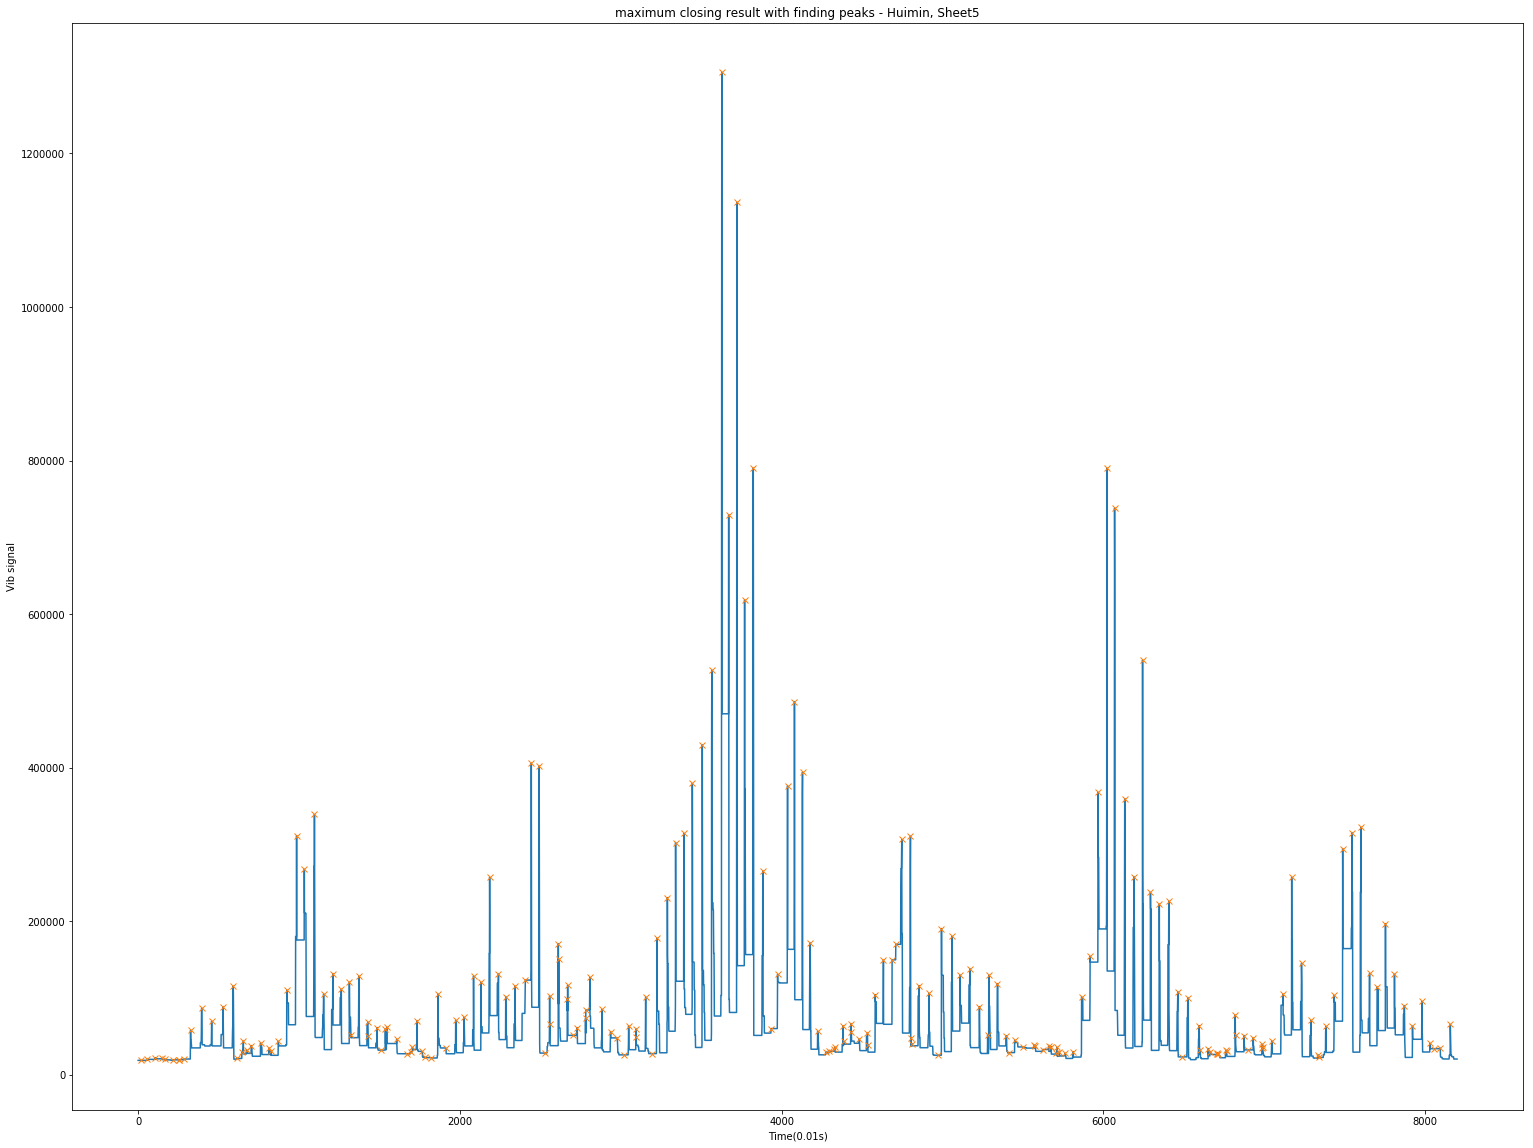

In [46]:
label_trajectory_filename = 'label_trajectory-time.xlsx'
sheetnames = ['Sheet1','Sheet2','Sheet3','Sheet4','Sheet5']
filenames = ['a673_corner.csv','dc04_bedroomb.csv','2a5f_corridor.csv',
             'ca46_sofa.csv','ae69_bedrooma.csv','ab05_laundry.csv']
footstep_count = {'Yu': [None for _ in range(5)],
                 'Shushan': [None for _ in range(5)],
                 'Huimin': [None for _ in range(5)],
                 'Zhen': [None for _ in range(5)],
                 'Hou': [None for _ in range(5)],
                 'Kai': [None for _ in range(5)],
                 'Sili': [None for _ in range(5)]}

for i in range(len(sheetnames)):
    sheetname = sheetnames[i]
    df = pd.read_excel(label_trajectory_filename,sheet_name=sheetname)
    personnames = list(df.index)
    for personname in personnames:
        time = list(map(str,list(df.loc[personname,:])))
        time = [t for t in time if not t=='nan']
        start_time = time[0]
        end_time = time[-1]
        cnt = aggrmorphology(start_time,end_time,filenames,personname,sheetname)
        footstep_count[personname][i] = cnt

result_df = pd.DataFrame(footstep_count)
result_df.to_csv('non_normalization_result_df.csv')
result_df